<a href="https://colab.research.google.com/github/tarachari3/3300_Proj1/blob/master/notebooks/picassoAnalysis/uteroPicassoAnalysis_l2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Read in files from NCBI GEO
!wget --quiet https://ftp.ncbi.nlm.nih.gov/geo/series/GSE149nnn/GSE149372/suppl/GSE149372_scRNA.MetaData.85.csv.gz
!wget --quiet https://ftp.ncbi.nlm.nih.gov/geo/series/GSE149nnn/GSE149372/suppl/GSE149372_scRNA.normalized.assay85.csv.gz

#integrated.scaled.assay105

In [ ]:
!gunzip *.gz

In [ ]:
!git clone https://github.com/hhcho/densvis.git

Cloning into 'densvis'...
remote: Enumerating objects: 145, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 145 (delta 3), reused 2 (delta 2), pack-reused 137
Receiving objects: 100% (145/145), 419.61 KiB | 6.88 MiB/s, done.
Resolving deltas: 100% (75/75), done.


In [ ]:
%cd /content/densvis/densne/

/content/densvis/densne


In [ ]:
!g++ sptree.cpp densne.cpp densne_main.cpp -o den_sne -O2
import densne

densne.cpp: In function ‘bool DENSNE::load_data(double**, int*, int*, int*, double*, double*, int*, int*, double*, double*, bool*, double**)’:
densne.cpp:961:8: warning: ignoring return value of ‘size_t fread(void*, size_t, size_t, FILE*)’, declared with attribute warn_unused_result [-Wunused-result]
   fread(n, sizeof(int), 1, h);                                            // number of datapoints
   ~~~~~^~~~~~~~~~~~~~~~~~~~~~
densne.cpp:962:8: warning: ignoring return value of ‘size_t fread(void*, size_t, size_t, FILE*)’, declared with attribute warn_unused_result [-Wunused-result]
   fread(d, sizeof(int), 1, h);                                            // original dimensionality
   ~~~~~^~~~~~~~~~~~~~~~~~~~~~
densne.cpp:963:8: warning: ignoring return value of ‘size_t fread(void*, size_t, size_t, FILE*)’, declared with attribute warn_unused_result [-Wunused-result]
   fread(theta, sizeof(double), 1, h);                                        // gradient accuracy
   ~~~~~^~~~~~~~~~

In [ ]:
%cd /content/

/content


In [ ]:
!git clone https://github.com/pachterlab/CP_2022.git

Cloning into 'CP_2022'...
remote: Enumerating objects: 490, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 490 (delta 31), reused 19 (delta 5), pack-reused 424
Receiving objects: 100% (490/490), 166.93 MiB | 21.14 MiB/s, done.
Resolving deltas: 100% (244/244), done.


In [ ]:
%cd /content/CP_2022/scripts

/content/CP_2022/scripts


In [ ]:
!pip3 install --quiet torch
!pip3 install --quiet anndata
!pip3 install --quiet matplotlib
!pip3 install --quiet scikit-learn
!pip3 install --quiet torchsummary
!pip install --quiet scanpy==1.6.0
!pip3 install --quiet umap-learn

     |████████████████████████████████| 96 kB 3.2 MB/s 
     |████████████████████████████████| 7.7 MB 4.2 MB/s 
     |████████████████████████████████| 88 kB 7.3 MB/s 
     |████████████████████████████████| 42 kB 1.5 MB/s 
     |████████████████████████████████| 1.1 MB 56.2 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 


## **Install Packages**

In [ ]:
import anndata 
import pandas as pd
import numpy as np

from Picasso import Picasso
import visualizations as vis
import tools as tl
import random
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.neighbors import NeighborhoodComponentsAnalysis, NearestNeighbors
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import scale
import torch
import time
import scanpy as sc
import seaborn as sns
import umap
from scipy import stats
import scipy.io as sio
import matplotlib
matplotlib.rc('axes',edgecolor='black')
%matplotlib inline
sc.set_figure_params(dpi=125)
sns.set_style('white')

## **Import Data**

In [ ]:
# General parameters
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['axes.linewidth'] = 0.1

state = 42
ndims = 2

data_path = '/content'

n_latent = 50
pcs = 50
pcs2 = 15

In [ ]:
#From assignments in Fig.2 and Extended Data Fig. 8 c in Aguilera-Castrejon et al. 2021
cell_types = {'0': 'Blood', '1': 'Somitic Mesoderm', '2': 'Foregut Mid-hindgut', '3': 'Cardiac', '4': 'Mid-hindbrain',
'5': 'Endothelial', '6': 'Presomitic/Mixed Mesoderm', '7':'Amnion', '8':'Extra-Embryonic Endoderm', '9':'Pharyngeal Mesoderm',
'10': 'Extra-Embryonic Ectoderm', '11': 'Blood' , '12':'Placodes', '13': 'Neural Tube', '14':'Extra-Embryonic Mesoderm',
'15':'Amnion', '16':'Neural Tube', '17':'Amnion', '18':'Endothelial'}


cdict = {'Blood':'#70D4CE','Presomitic/Mixed Mesoderm':'#81A483','Foregut Mid-hindgut':'#4D50E3',
        'Cardiac':'#E0B7CF','Mid-hindbrain':'#FC514A','Endothelial':'#EDE7D1',
        'Amnion':'#B4CA72',
        'Extra-Embryonic Endoderm':'#C7A2F3','Pharyngeal Mesoderm':'#CCD0BC','Extra-Embryonic Ectoderm':'#73F0FD',
        'Placodes':'#AE995B','Neural Tube':'#87BD7E','Somitic Mesoderm':'#D34FEA',
        'Extra-Embryonic Mesoderm':'#0F5813'}

Reading in log-normalized counts only

In [ ]:
counts = pd.read_csv(data_path+'/GSE149372_scRNA.normalized.assay85.csv',index_col=0)
print(counts.head())


cellMeta = pd.read_csv(data_path+'/GSE149372_scRNA.MetaData.85.csv')
print(cellMeta.head())

        AAACGAAAGTCCCGAC-1  AAACGAAGTCGAGTTT-1  AAACGCTAGGACTTCT-1  \
Xkr4              0.000000            0.000000            0.000000   
Rp1               0.000000            0.000000            0.597661   
Sox17             0.000000            0.000000            0.000000   
Mrpl15            1.175618            0.559627            0.597661   
Lypla1            0.751450            0.916306            0.597661   

        AAACGCTCAACGCCCA-1  AAACGCTTCTGTGCGG-1  AAACGCTTCTTCTAAC-1  \
Xkr4                   0.0            0.000000            0.000000   
Rp1                    0.0            0.000000            0.000000   
Sox17                  0.0            0.000000            0.000000   
Mrpl15                 0.0            1.487989            0.770525   
Lypla1                 0.0            0.000000            0.000000   

        AAAGAACGTCTACACA-1  AAAGAACTCGACGACC-1  AAAGGATCAGTTCTAG-1  \
Xkr4                   0.0                 0.0            0.000000   
Rp1               

In [ ]:
#Center and scale log-normalized data
count_mat = counts.values.T

In [ ]:
adata = anndata.AnnData(X = count_mat)
adata.obs_names = list(counts.columns)
adata.var_names = list(counts.index)
adata.obs['Utero'] = pd.Categorical(cellMeta.Utero)
adata.obs['Cluster'] = pd.Categorical(cellMeta.seurat_clusters)
adata

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  """Entry point for launching an IPython kernel.


AnnData object with n_obs × n_vars = 10290 × 19588
    obs: 'Utero', 'Cluster'

In [ ]:
exAdata = adata[adata.obs['Utero']=='ExUt']
inAdata = adata[adata.obs['Utero']=='InUt']
exAdata

View of AnnData object with n_obs × n_vars = 6205 × 19588
    obs: 'Utero', 'Cluster'

In [ ]:
#In paper, use top 2000 HVGs and 15 PCs
def scaleAdata(adata):
  sc.pp.filter_cells(adata, min_counts=0)
  sc.pp.filter_genes(adata, min_counts=0)


  sc.pp.highly_variable_genes(adata,n_top_genes=2000)

  adata = adata[:,adata.var['highly_variable']]
  adata.obsm['log'] = adata.X

  sc.pp.scale(adata, max_value=10)
  return adata

In [ ]:
adata = scaleAdata(adata)
exAdata = scaleAdata(exAdata)
inAdata = scaleAdata(inAdata)

/usr/local/lib/python3.7/dist-packages/scanpy/preprocessing/_simple.py:128: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  if min_genes is None and max_genes is None: adata.obs['n_counts'] = number


In [ ]:
toUseAdata = inAdata
count_mat = toUseAdata.obsm['log']
scaled_mat = toUseAdata.X

In [ ]:
#Set colors for cell clusters
colors = np.random.rand(len(toUseAdata.obs['Cluster']),3)

labs = np.array([list(toUseAdata.obs['Cluster']),list(toUseAdata.obs['Utero'])])

# adata.obs['Cluster'].value_counts()

Function for calculating inter/intra metrics

In [ ]:
def getAllVars(latents,latentLab,latentType):
  '''Get all intra- and inter-distances for input latent space, and Pearson 
  correlation of those distances to ambient space'''
  emb = []

  vals = []

  dist = []

  dim = []

  allVals = pd.DataFrame()

  for p in range(len(latents)):

    i = latents[p]
    l = latentLab[p]
    d = latentType[p]

    c = tl.getCentroidDists(i, labs[0],m='l2')

    intraC = tl.getIntraVar(i, labs[0],labs[0],m='l2')
  
    vals += [stats.pearsonr(c, amb)[0], stats.pearsonr(intraC, ambIntraC)[0]]
  
    dist += ['Inter-Type','Intra-Type'] 

    emb += [l]*2
    dim += [d]*2


  allVals['Latent'] = emb
  allVals['Distance'] = dist
  allVals['Pearsonr'] = vals
  allVals['Dimension'] = dim


  return allVals


In [ ]:
def getJac(orig_indices,latents, latentLab, n_neighbors=30,set_p=1):
  emb = []

  xs = []

  ys = []

  knnDF = pd.DataFrame()

  for p in range(len(latents)):
    i = latents[p]
    l = latentLab[p]

    ind = tl.getNeighbors(i, n_neigh = n_neighbors,p=set_p)

    x = tl.getJaccard(orig_indices,ind)

    xs += x
    #ys += list(y)

    emb += [l]*len(x)

    print(l)

    print(np.mean(tl.getJaccard(orig_indices,ind)))



  knnDF['x'] = xs
  #knnDF['y'] = ys
  knnDF['latent'] = emb

  return knnDF

In [ ]:
#Get fraction of k-nearest neighbors that are the same as in the ambient space
def getAllKNNs(orig_indices,latents,latentLab,latentType):
  emb = []

  frac = []


  knnDF = pd.DataFrame()

  for p in range(len(latents)):
    i = latents[p]
    l = latentLab[p]

    ind = tl.getNeighbors(i, n_neigh = 10,p=1)

    frac += [np.mean(tl.getIntersect(orig_indices,ind))]



    emb += [l]


  knnDF['Fraction'] = frac
  knnDF['Latent'] = emb

  return knnDF

### **Picasso Analysis**

In [ ]:
rounds = 5 #3

In [ ]:
batch_size = 128 #scaled_mat.shape[0]#len(adata.obs_names)
#Make a (unit) circle 
#r = 1
theta = np.linspace(0, 2*np.pi, batch_size)
# #Turkey guy
# x, y = (np.sin(2**theta) - 1.7) * np.cos(theta), (np.sin(2**theta) - 1.7) * np.sin(theta)

# #Butterfly r = 4*cos(4cosθ))
# x, y = (2*np.cos(4*np.cos(theta))) * np.cos(theta), (2*np.cos(4*np.cos(theta))) * np.sin(theta)

# # Spiral
#x, y = (1/2)*theta * np.cos(theta), (1/2)*theta * np.sin(theta)

# #Quasi-rose
x, y = (4 + np.cos(6*theta)) * np.cos(theta), (4 + np.cos(6*theta)) * np.sin(theta)


#Make array input for dimension of shape 
coords = np.array([list(x),list(y)])

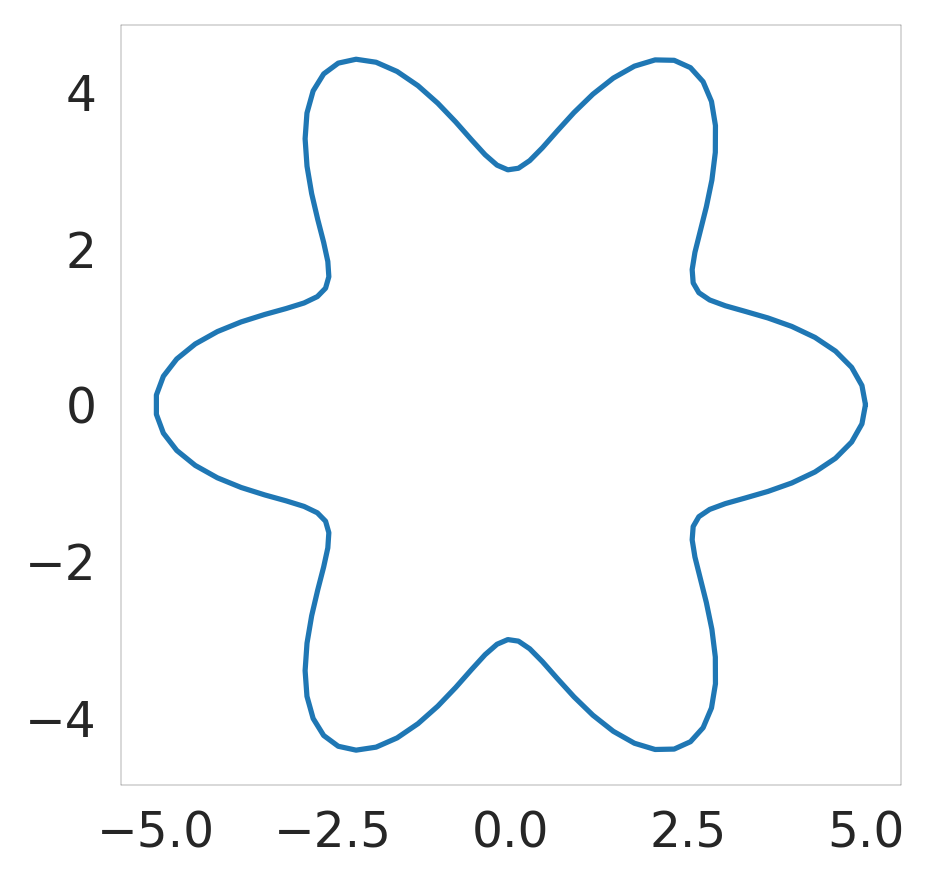

In [ ]:
plt.plot(x,y)

Set Ambient Data

In [ ]:
toUseAdata = inAdata  #Change to exData as well
count_mat = toUseAdata.obsm['log']
scaled_mat = toUseAdata.X

#Set colors for cell clusters
colors = np.random.rand(len(toUseAdata.obs['Cluster']),3)

labs = np.array([list(toUseAdata.obs['Cluster']),list(toUseAdata.obs['Utero'])])

In [ ]:
fullNames = [cell_types[str(i)] for i in labs[0]]

In [ ]:
amb = tl.getCentroidDists(count_mat,labs[0])
ambIntraC = tl.getIntraVar(count_mat, labs[0], labs[0])

In [ ]:
#In utero
fl = []
flLab = []
flType = []

for i in range(rounds):
  nca = Picasso(n_latent = 2, epochs = 1000, batch_size = batch_size)
  lossesB, latentB = nca.fit(scaled_mat,coords, frac = .05,silent=True,ret_loss=True)  #.06 for ex utero

  fl += [latentB]
  flLab += ['Flower']
  flType += ['MCML 2D']


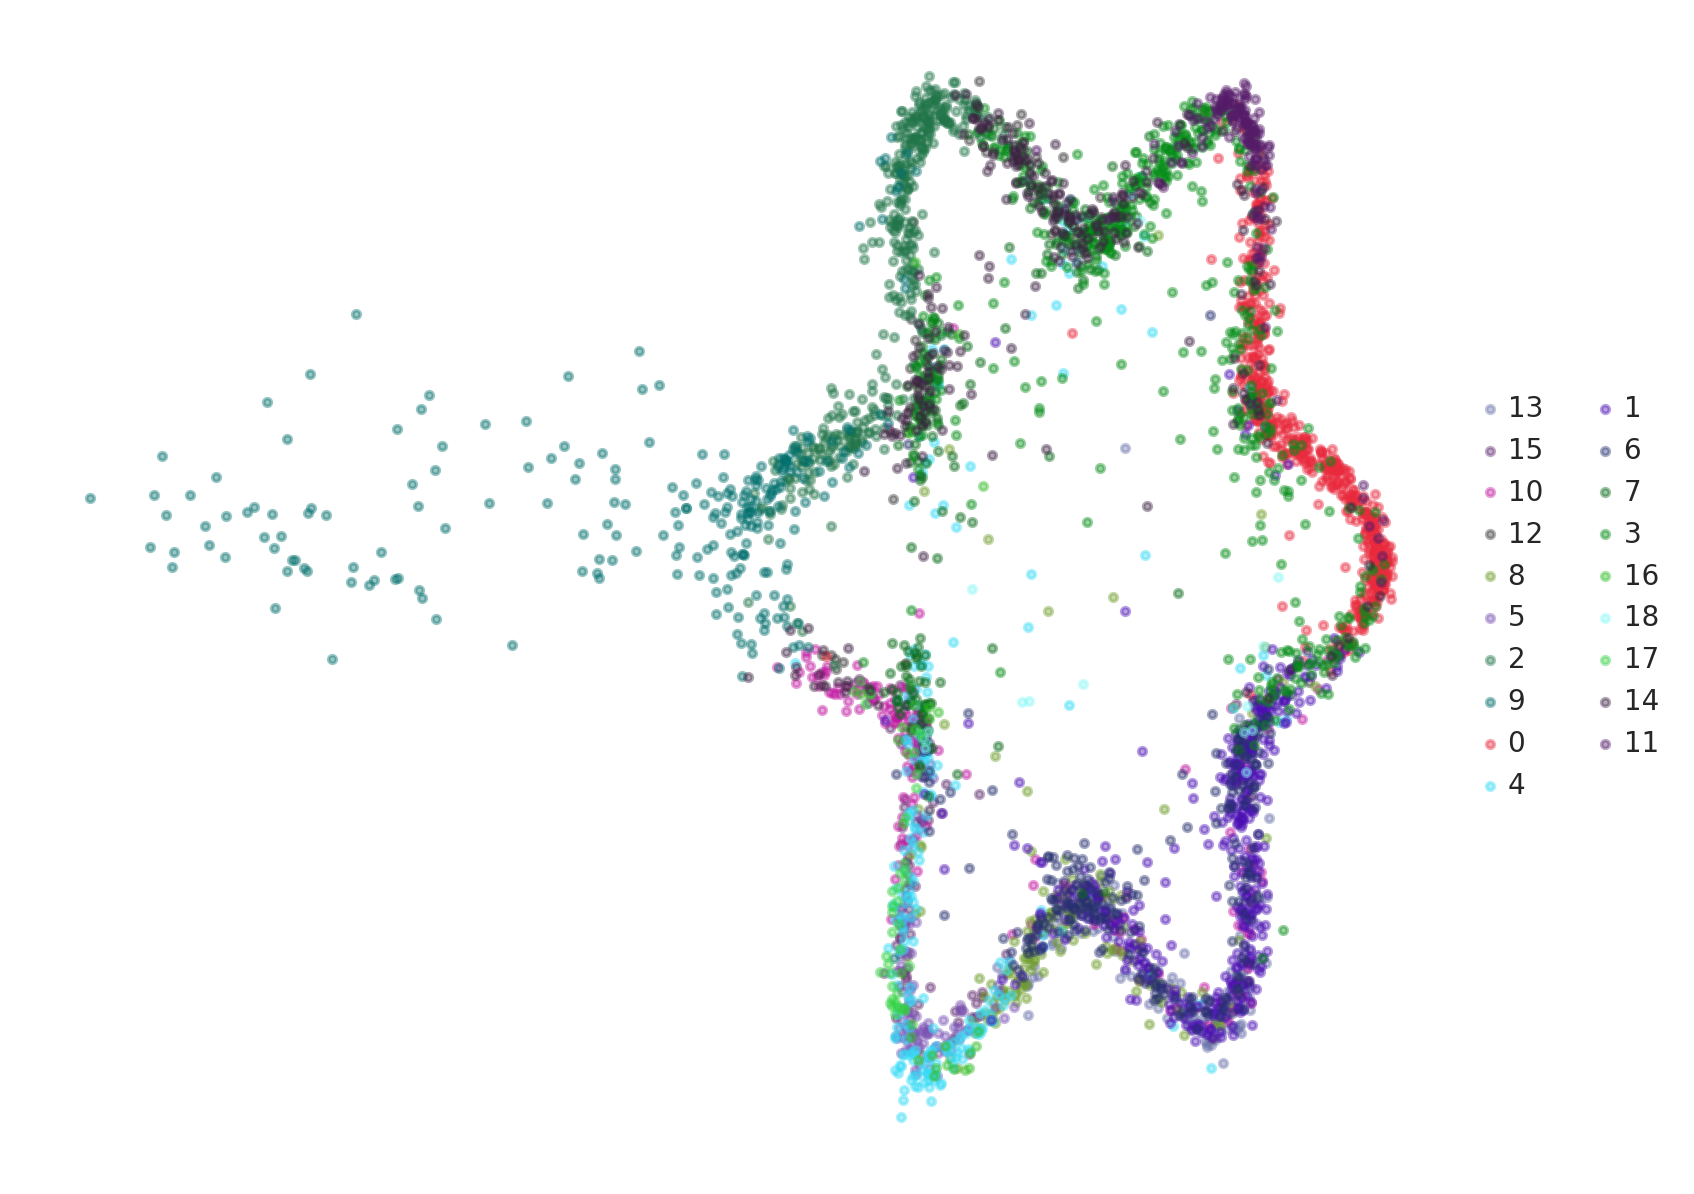

In [ ]:


vis.obj_plot_embed(latentB, fullNames, fname = '2DNCA.pdf', colors=colors )


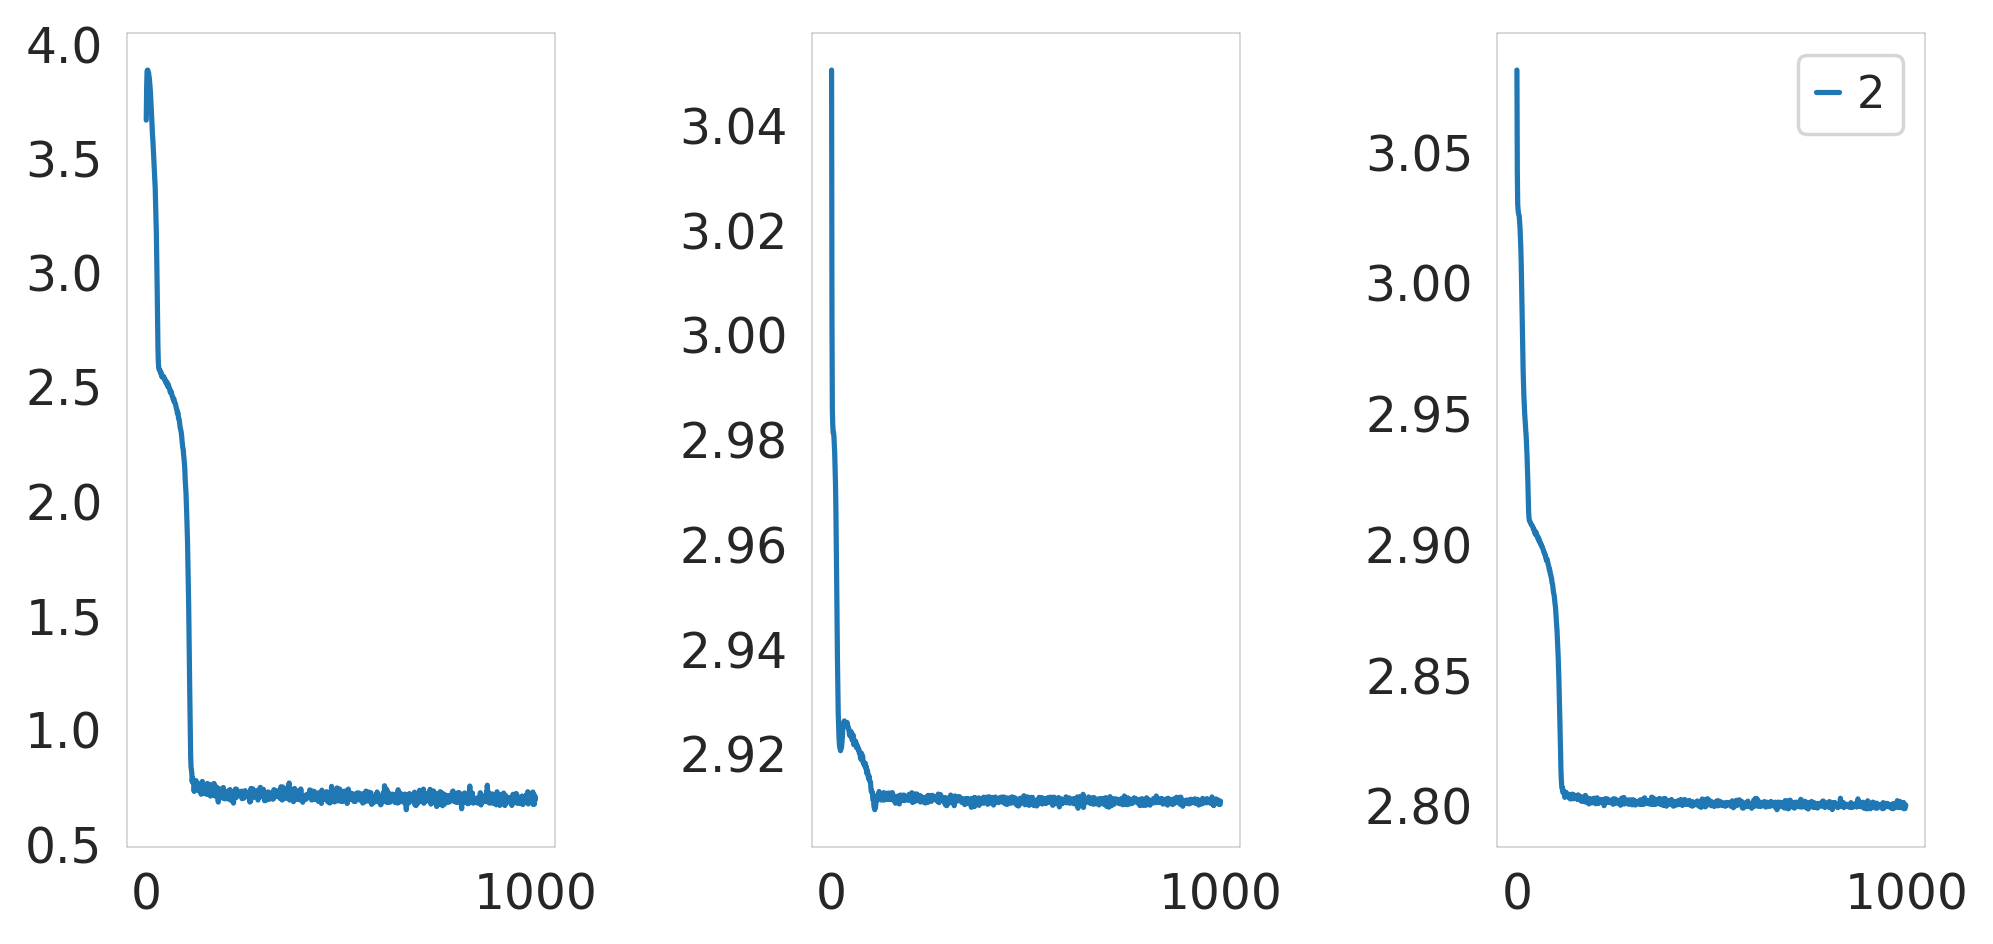

In [ ]:
fig, axs = plt.subplots(1, 3,figsize=(8,4))
for i in range(lossesB.shape[1]):
  axs[i].plot(lossesB[:,i],label=str(i))
  
plt.legend()
plt.tight_layout()
plt.show()

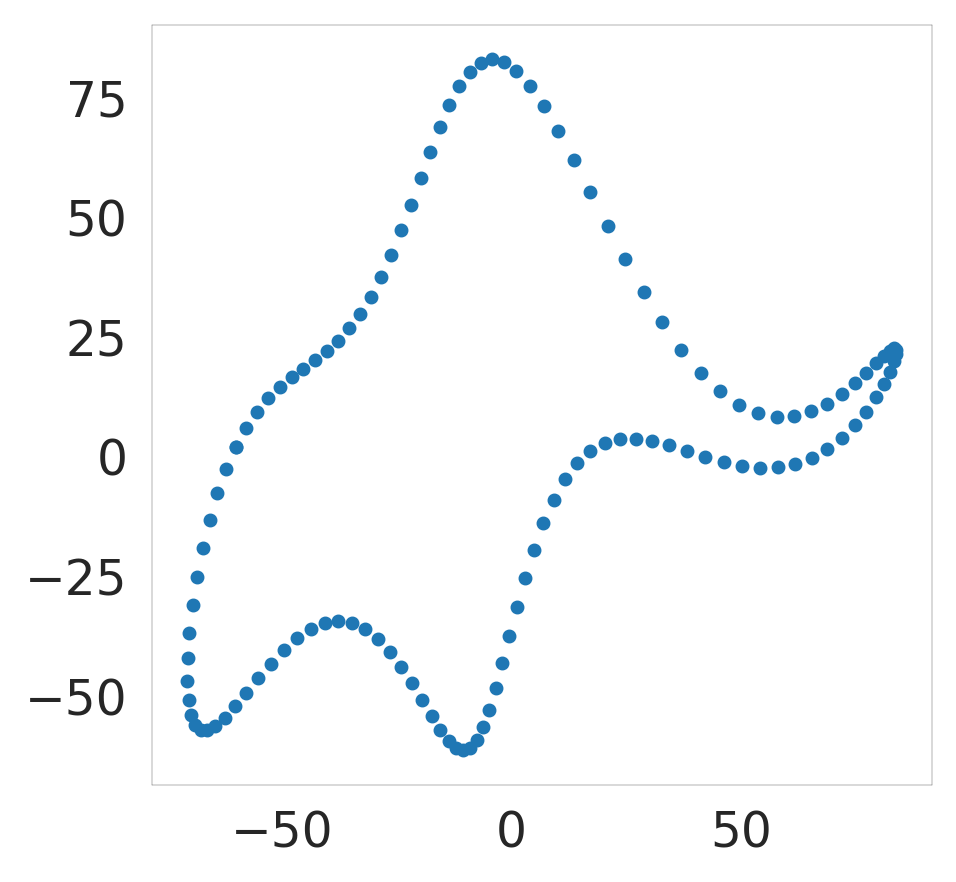

In [ ]:
# elephant parameters
batch_size = 128 #scaled_mat.shape[0]#3850 # 50

p1, p2, p3, p4 = (50 - 30j, 18 +  8j, 12 - 10j, -14 - 60j )
p5 = 40 + 20j # eyepiece

def fourier(t, C):
    f = np.zeros(t.shape)
    A, B = C.real, C.imag
    for k in range(len(C)):
        f = f + A[k]*np.cos(k*t) + B[k]*np.sin(k*t)
    return f

def elephant(t, p1, p2, p3, p4, p5):
    npar = 6
    Cx = np.zeros((npar,), dtype='complex')
    Cy = np.zeros((npar,), dtype='complex')

    Cx[1] = p1.real*1j
    Cx[2] = p2.real*1j
    Cx[3] = p3.real
    Cx[5] = p4.real

    Cy[1] = p4.imag + p1.imag*1j
    Cy[2] = p2.imag*1j
    Cy[3] = p3.imag*1j

    # x = np.append(fourier(t,Cx), [-p5.imag]) #[-p5.imag]
    # y = np.append(fourier(t,Cy), [p5.imag]) #[p5.imag]
    x = fourier(t,Cx)
    y = fourier(t,Cy)

    return x,y

x, y = elephant(np.linspace(0,2*np.pi,batch_size), p1, p2, p3, p4, p5)

#Make array input for dimension of shape 

y = y#0.04*y #.025  .025    .025
x = x#0.02*x #.015   .02     .015
# y = 0.02*y  
# x = 0.01*x

coords = np.array([list(y),list(-x)])

plt.plot(y,-x,'.')
plt.show()


In [ ]:
#Test with task assignment in-utero
el = []
elLab = []
elType = []

for i in range(rounds):
  nca = Picasso(n_latent = 2, epochs = 1000, batch_size = batch_size)
  lossesEl, latentEl = nca.fit(scaled_mat,coords, frac = 0.035,silent=True,ret_loss=True) #.06

  el += [latentEl]
  elLab += ['Elephant']
  elType += ['MCML 2D']

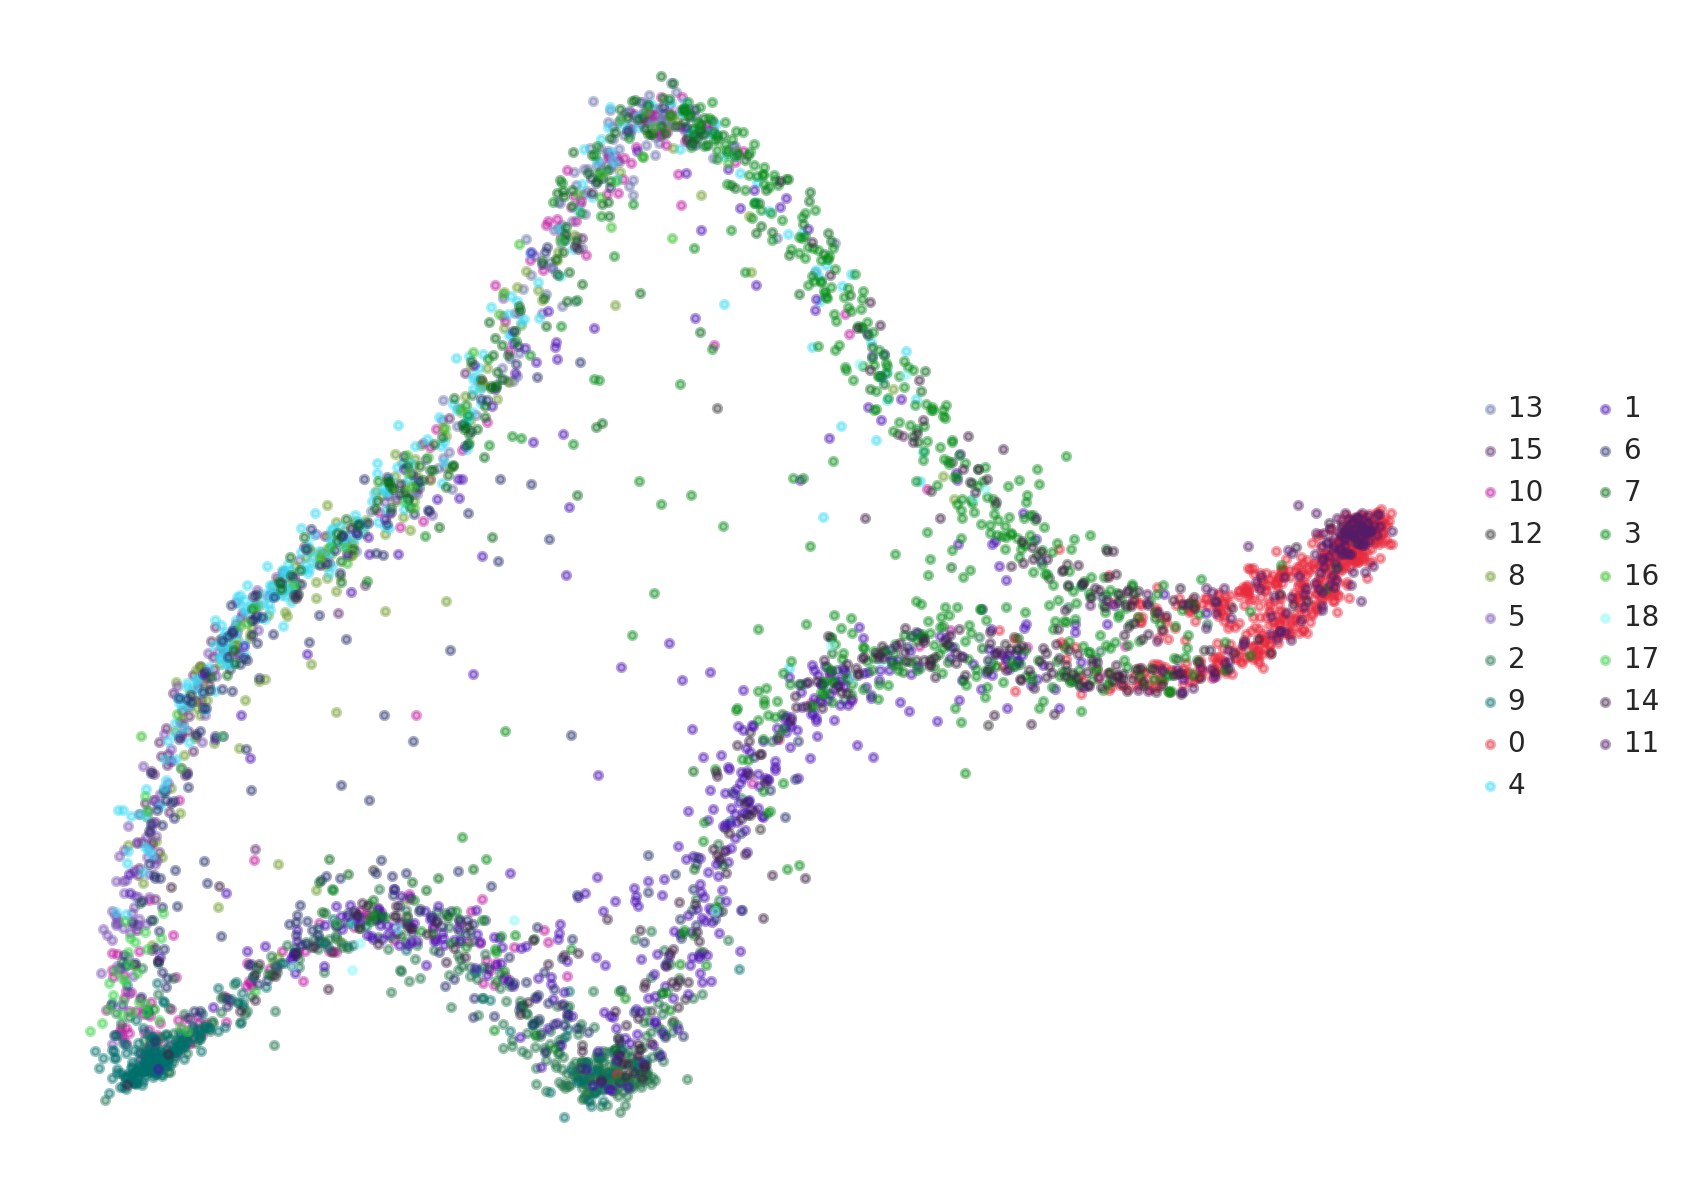

In [ ]:



vis.obj_plot_embed(latentEl, fullNames, fname = '2DNCA.pdf', colors=colors )


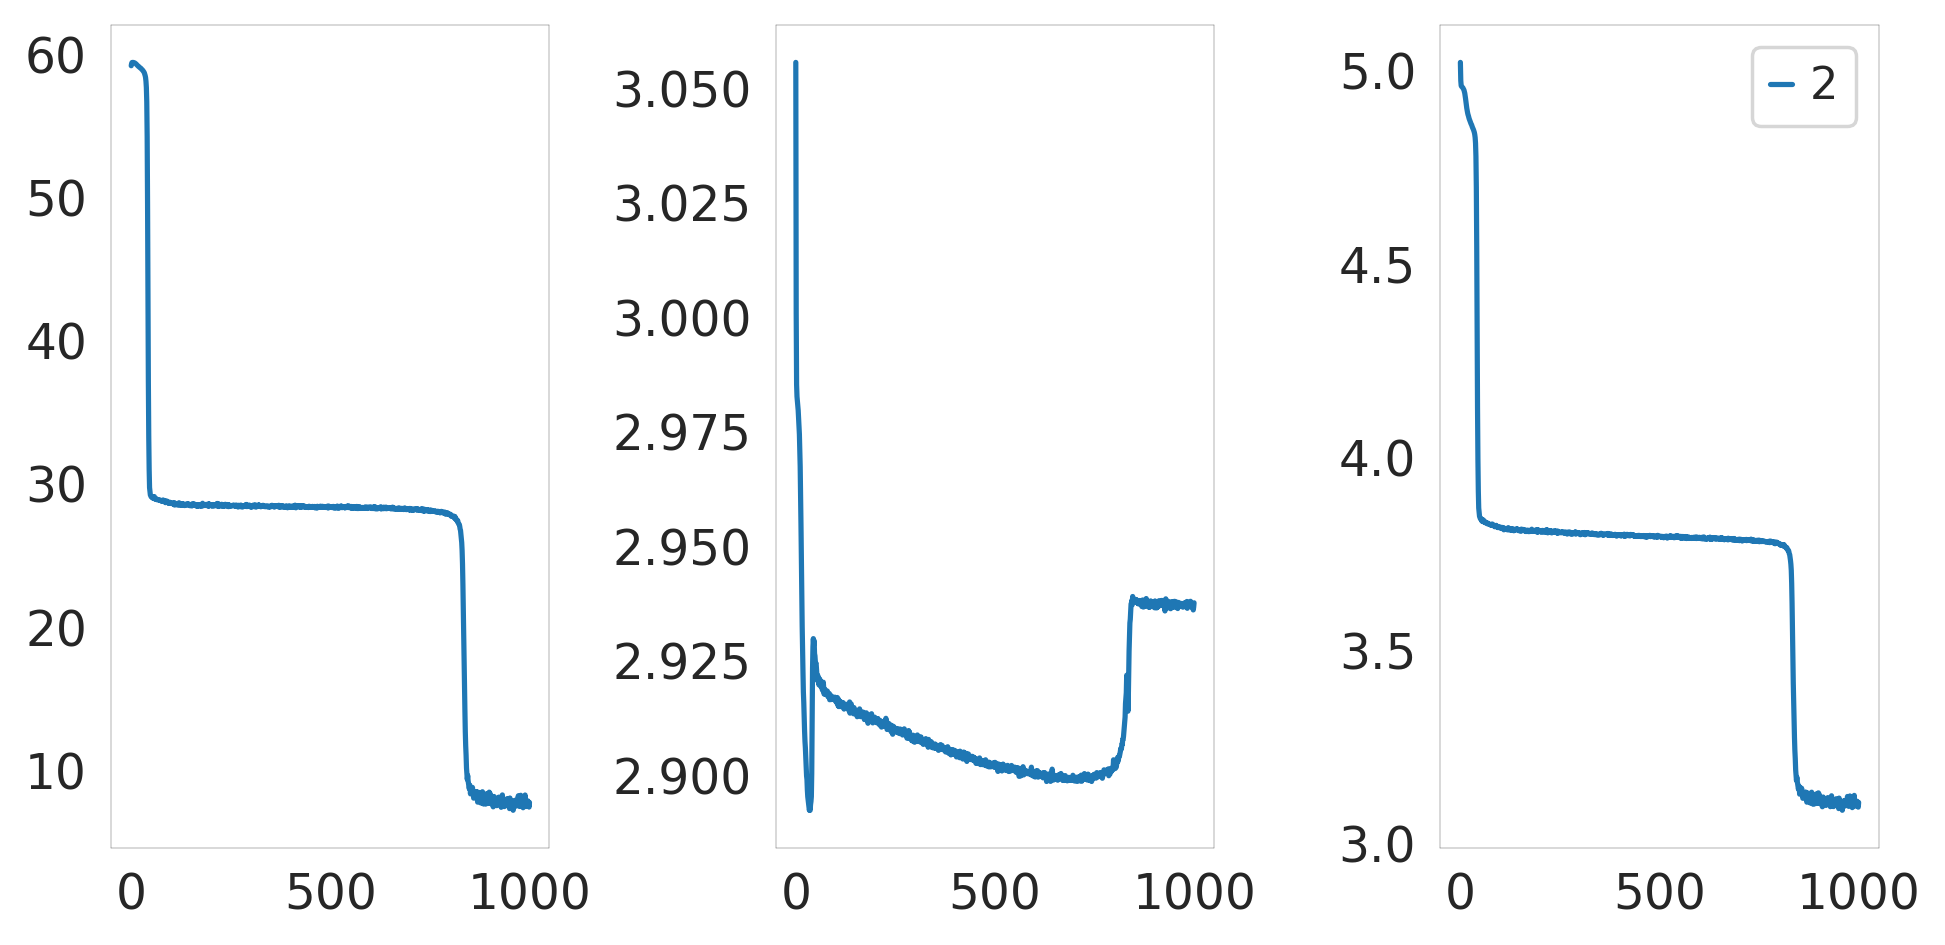

In [ ]:
fig, axs = plt.subplots(1, 3,figsize=(8,4))
for i in range(lossesEl.shape[1]):
  axs[i].plot(lossesEl[:,i],label=str(i))
  
plt.legend()
plt.tight_layout()
plt.show()

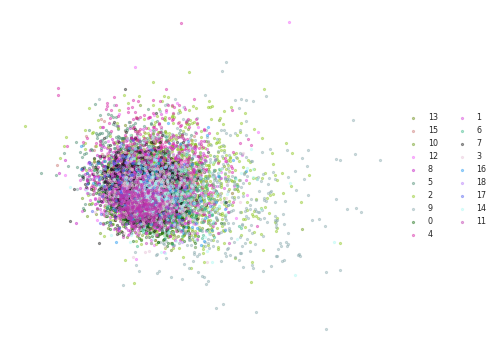

In [ ]:
# #No training
# ncaNoT = Picasso(n_latent = 2, epochs = 0, batch_size = batch_size)
# lossesNoT, latentNoT = ncaNoT.fit(scaled_mat,coords, fracNCA = 1,silent=True,ret_loss=True)


# vis.obj_plot_embed(latentNoT, labs[0], fname = '2DNCA.pdf', colors=colors )


Get latent spaces for comparison (baselines)

In [ ]:
latents,latentLab,latentType = tl.visComp(scaled_mat, ndims=2, pcs=50)

Compare flower embedding

In [ ]:
latents = fl + latents

latentLab = flLab + latentLab

latentType = flType + latentType

In [ ]:
allVals = getAllVars(latents,latentLab,latentType)

In [ ]:
toRemove = ['Recon MCML denSNE','PCA densSNE','Recon MCML densMAP','PCA densMAP','PCA 50D']
subAllVals = allVals[~allVals['Latent'].isin(toRemove)]

In [ ]:
vis.plotLatentStats(allVals, axisFontSize = 11, tickFontSize = 10)

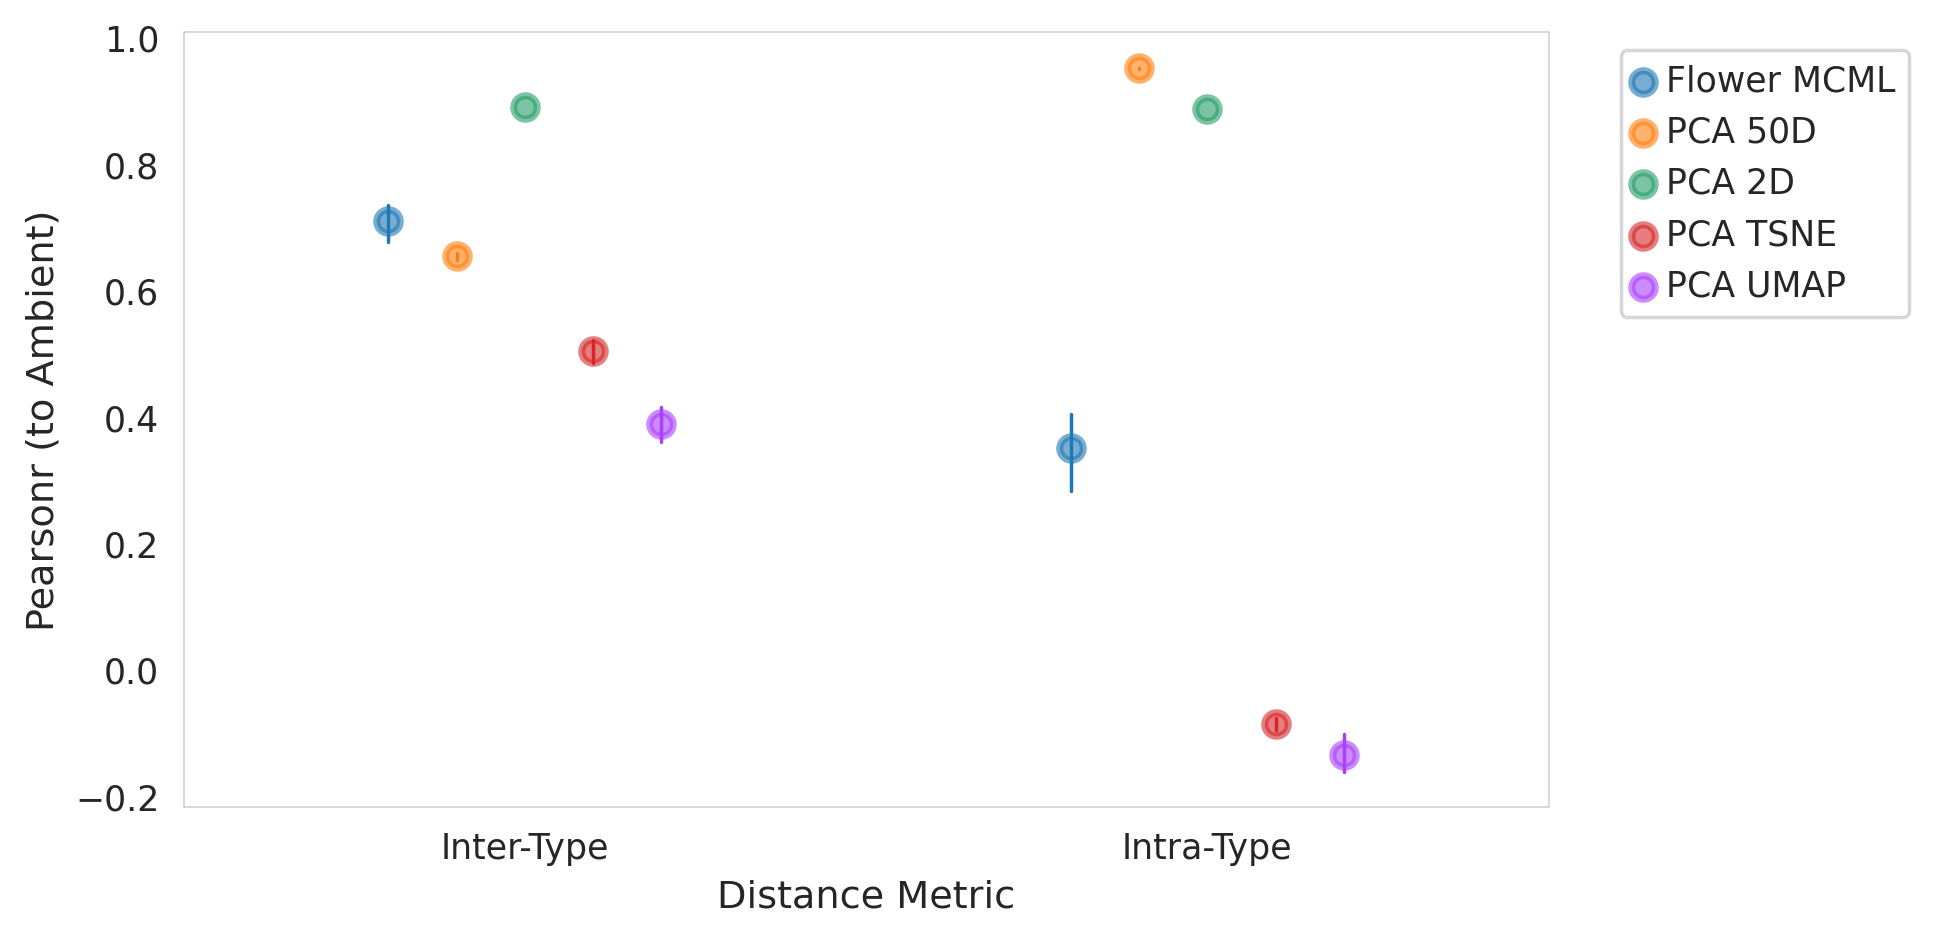

In [ ]:
vis.plotLatentStats(subAllVals, axisFontSize = 11, tickFontSize = 10)

Compare elephant embedding

In [ ]:
latents = el + latents

latentLab = elLab + latentLab

latentType = elType + latentType

In [ ]:
allVals = getAllVars(latents,latentLab,latentType)
allVals = allVals[~allVals['Latent'].isin(['Flower'])]

In [ ]:
toRemove = ['Recon MCML denSNE','PCA densSNE','Recon MCML densMAP','PCA densMAP','PCA 50D']
subAllVals = allVals[~allVals['Latent'].isin(toRemove)]

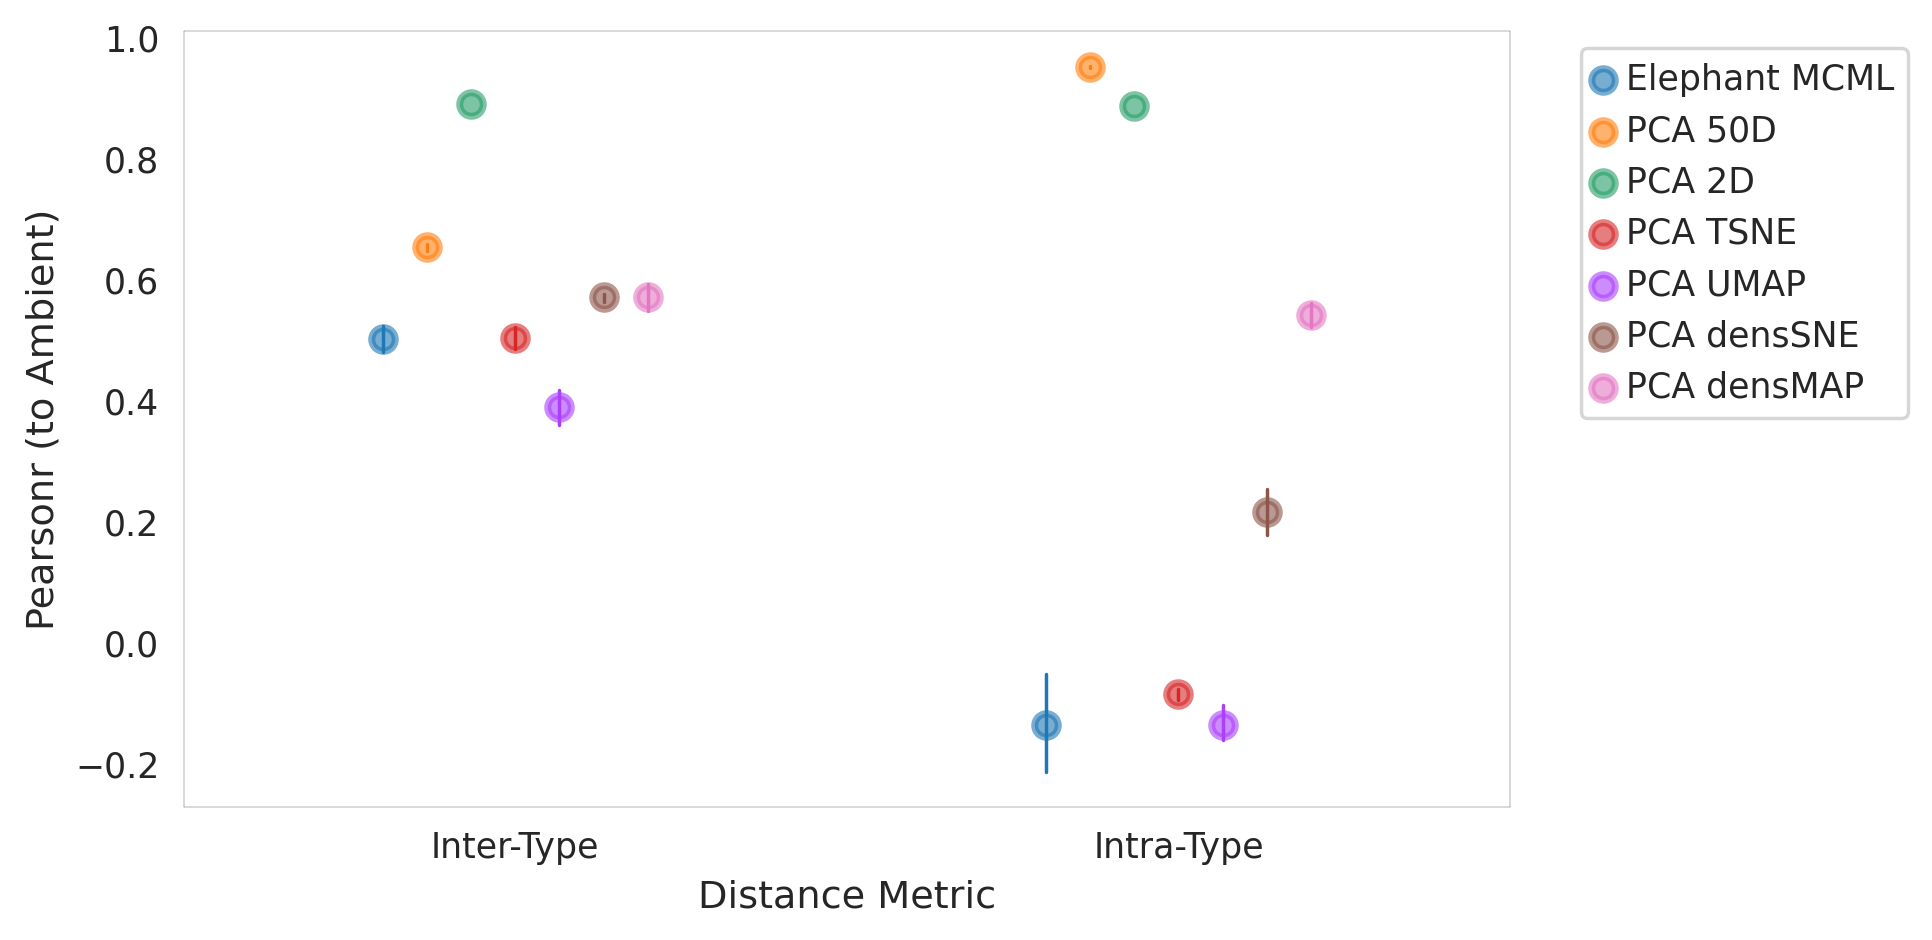

In [ ]:
vis.plotLatentStats(allVals, axisFontSize = 11, tickFontSize = 10)

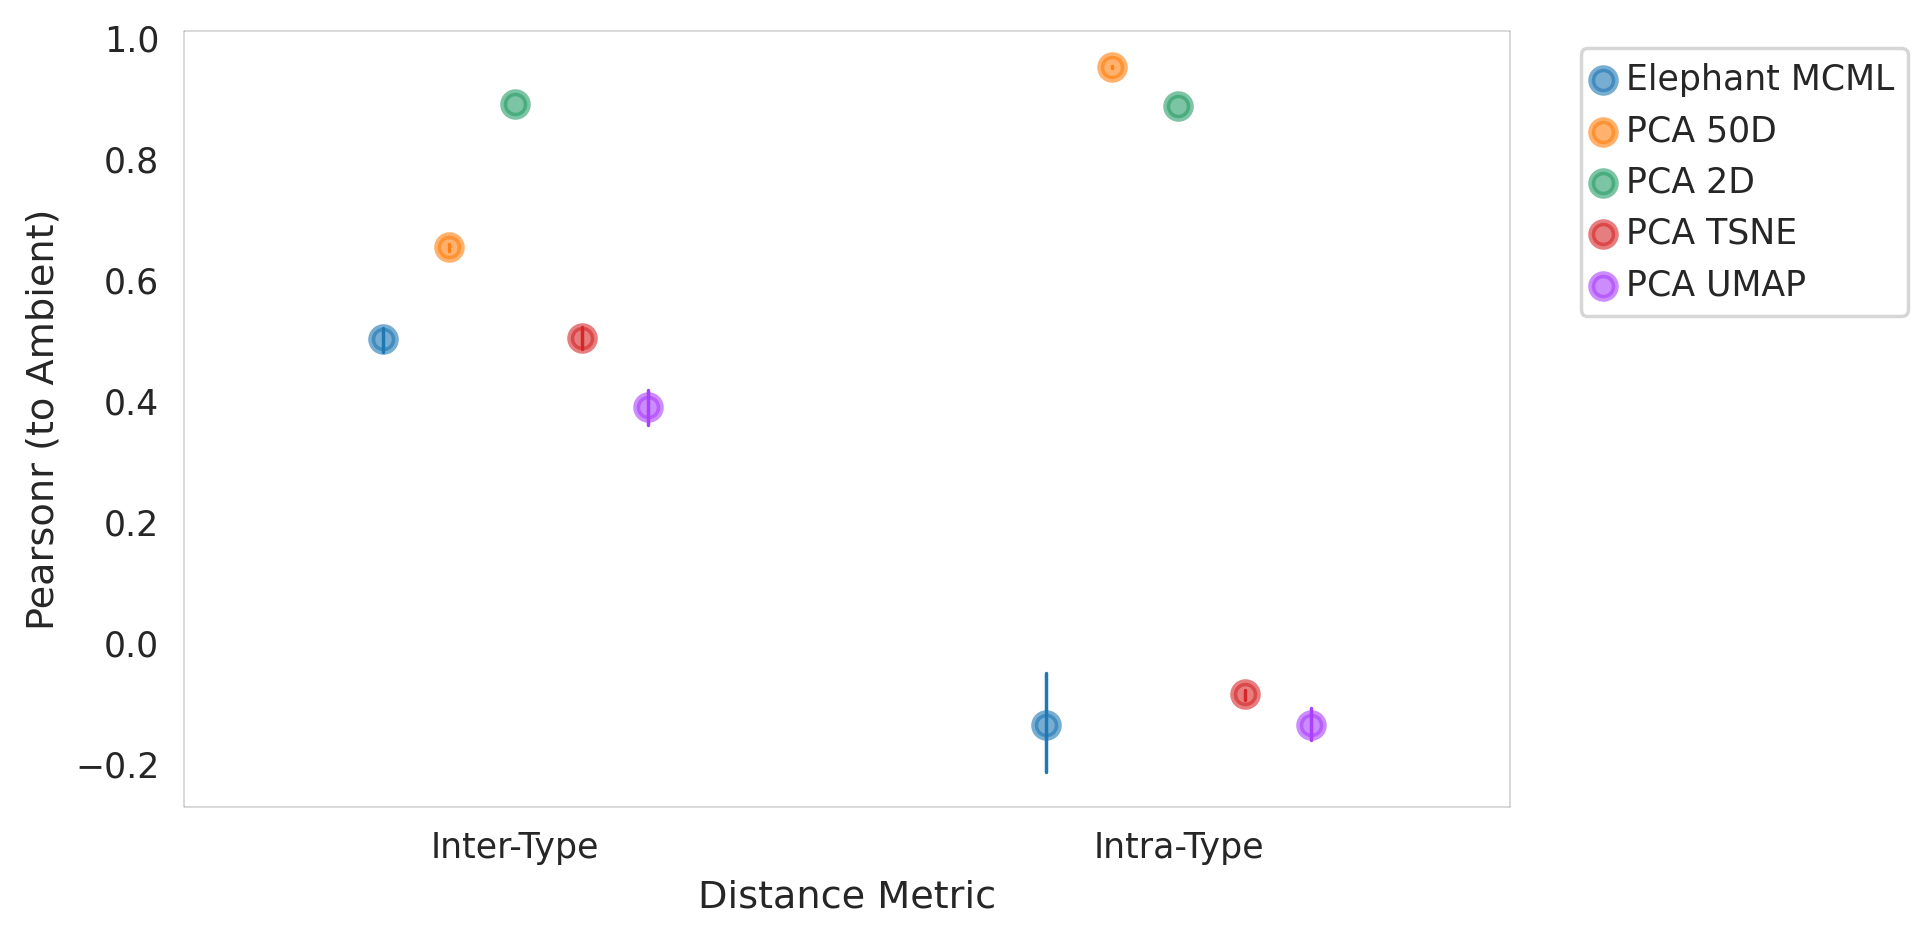

In [ ]:
vis.plotLatentStats(subAllVals, axisFontSize = 11, tickFontSize = 10)

**Test Ex-Utero Data**

Set Ambient Data

In [ ]:
toUseAdata = exAdata  #Change to exData as well
count_mat = toUseAdata.obsm['log']
scaled_mat = toUseAdata.X

#Set colors for cell clusters (Use same colors as in utero data)
#colors = np.random.rand(len(toUseAdata.obs['Cluster']),3)

labs = np.array([list(toUseAdata.obs['Cluster']),list(toUseAdata.obs['Utero'])])

In [ ]:
fullNames = [cell_types[str(i)] for i in labs[0]]

In [ ]:
colors = [cdict[i] for i in pd.unique(fullNames)]

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


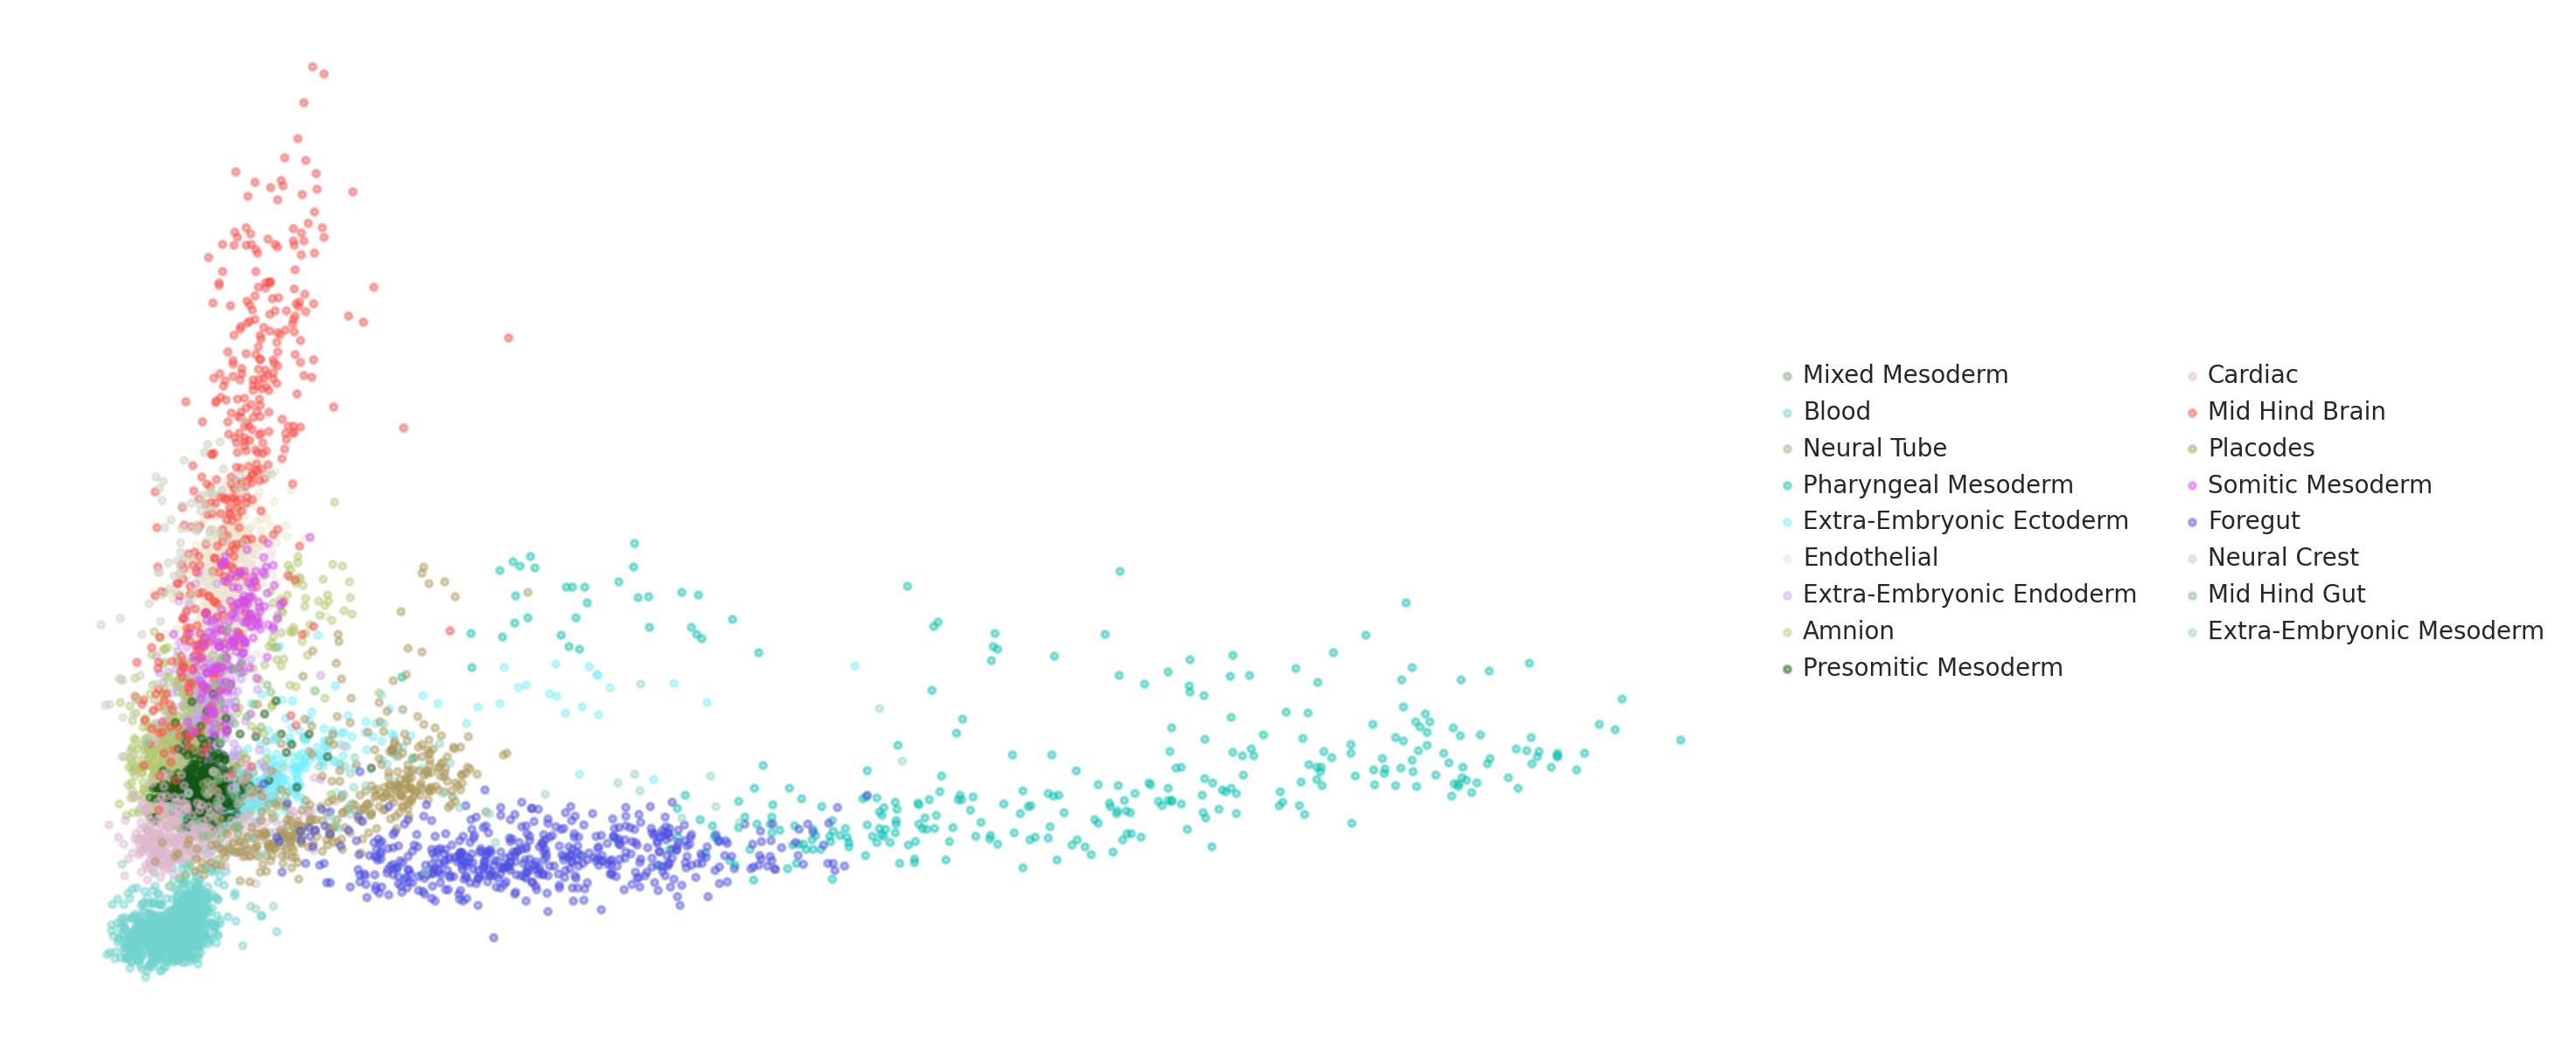

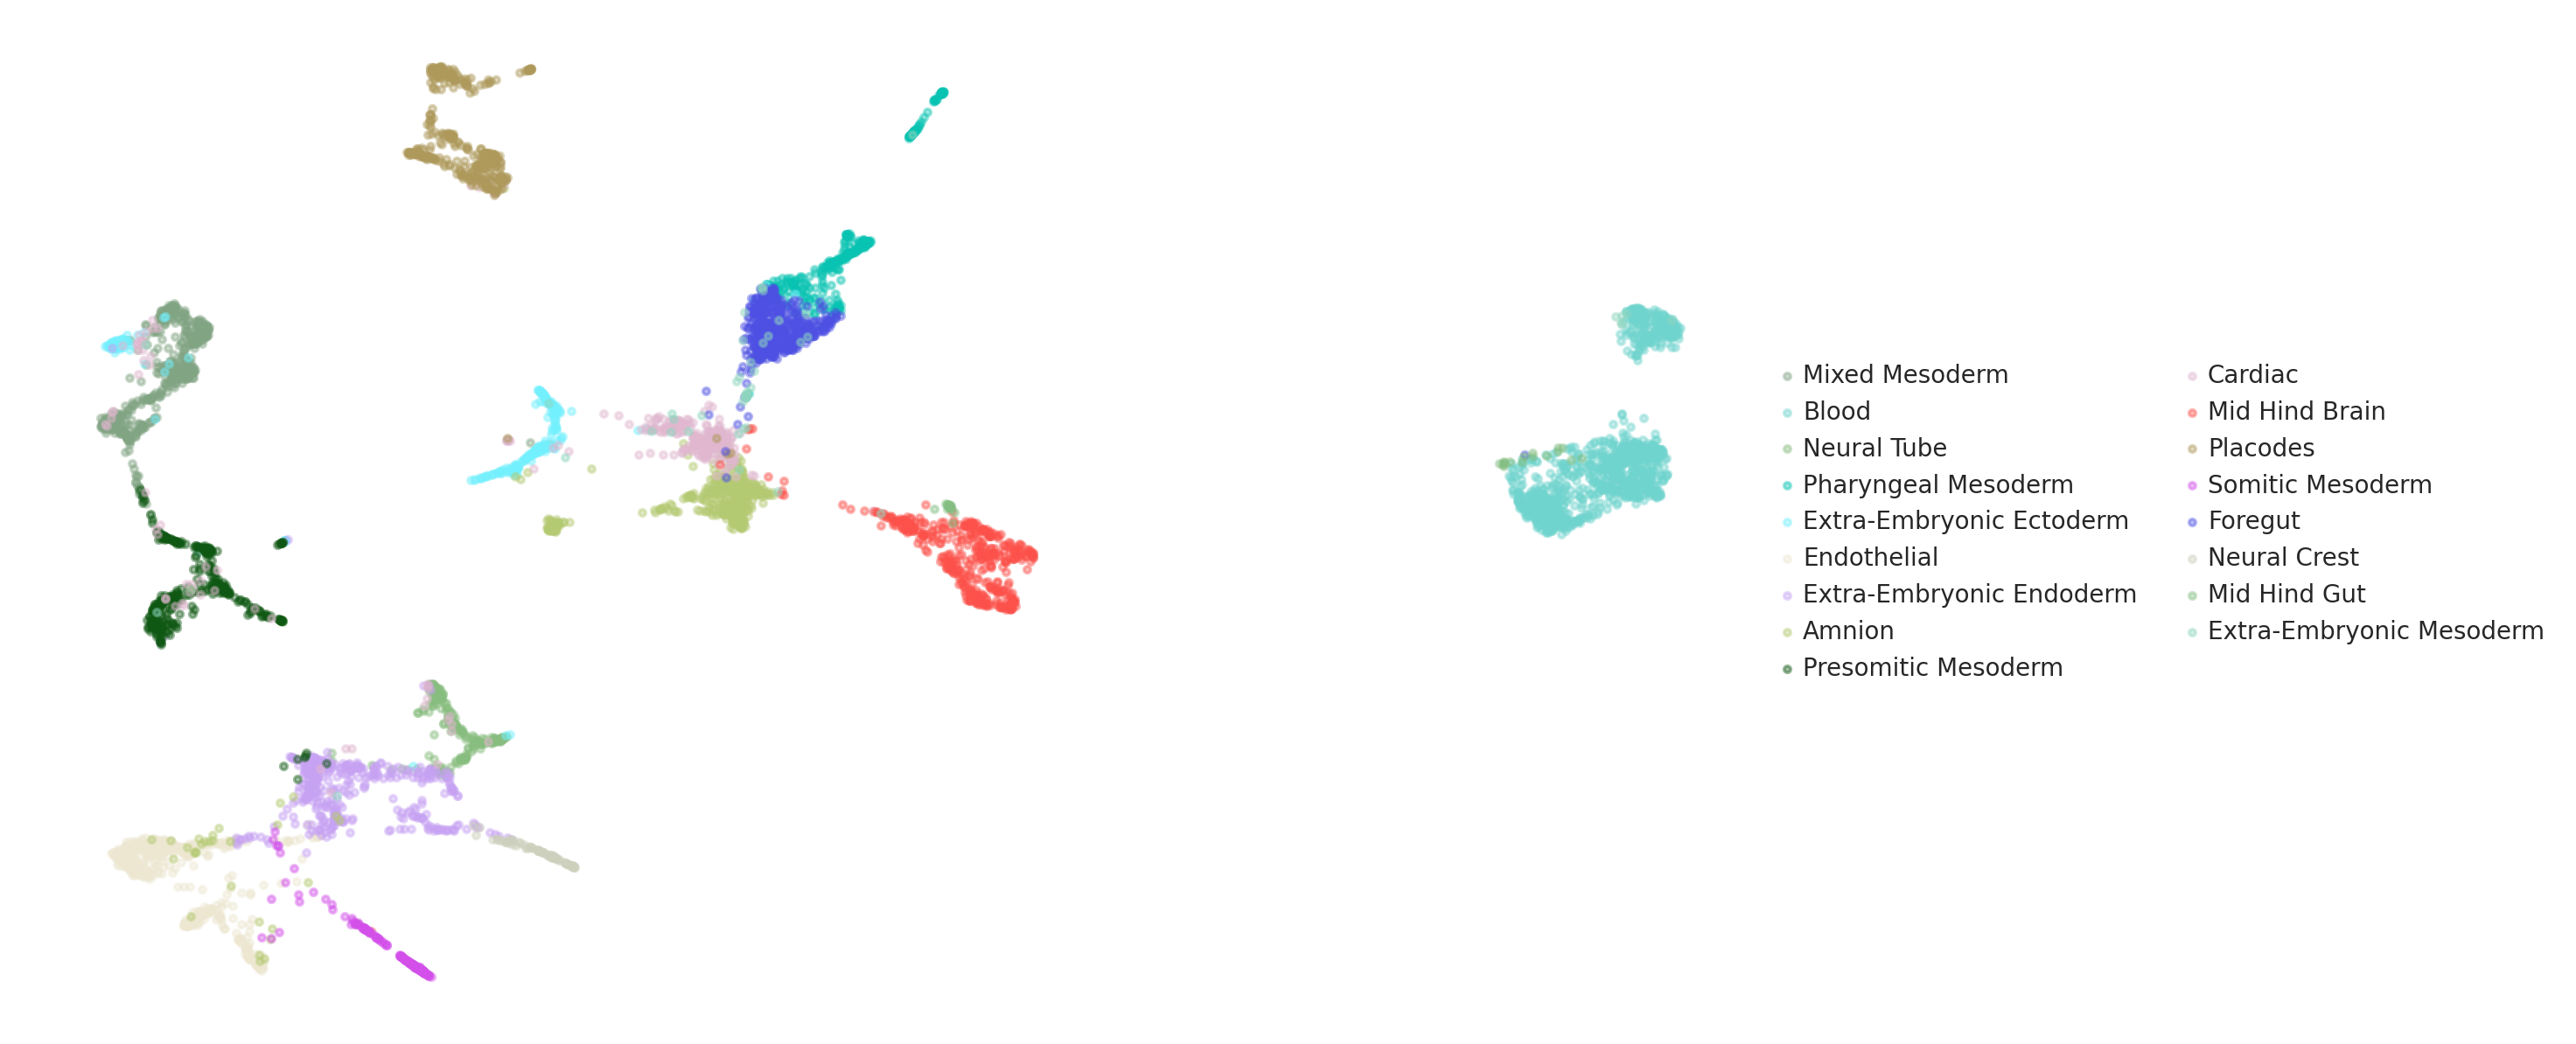

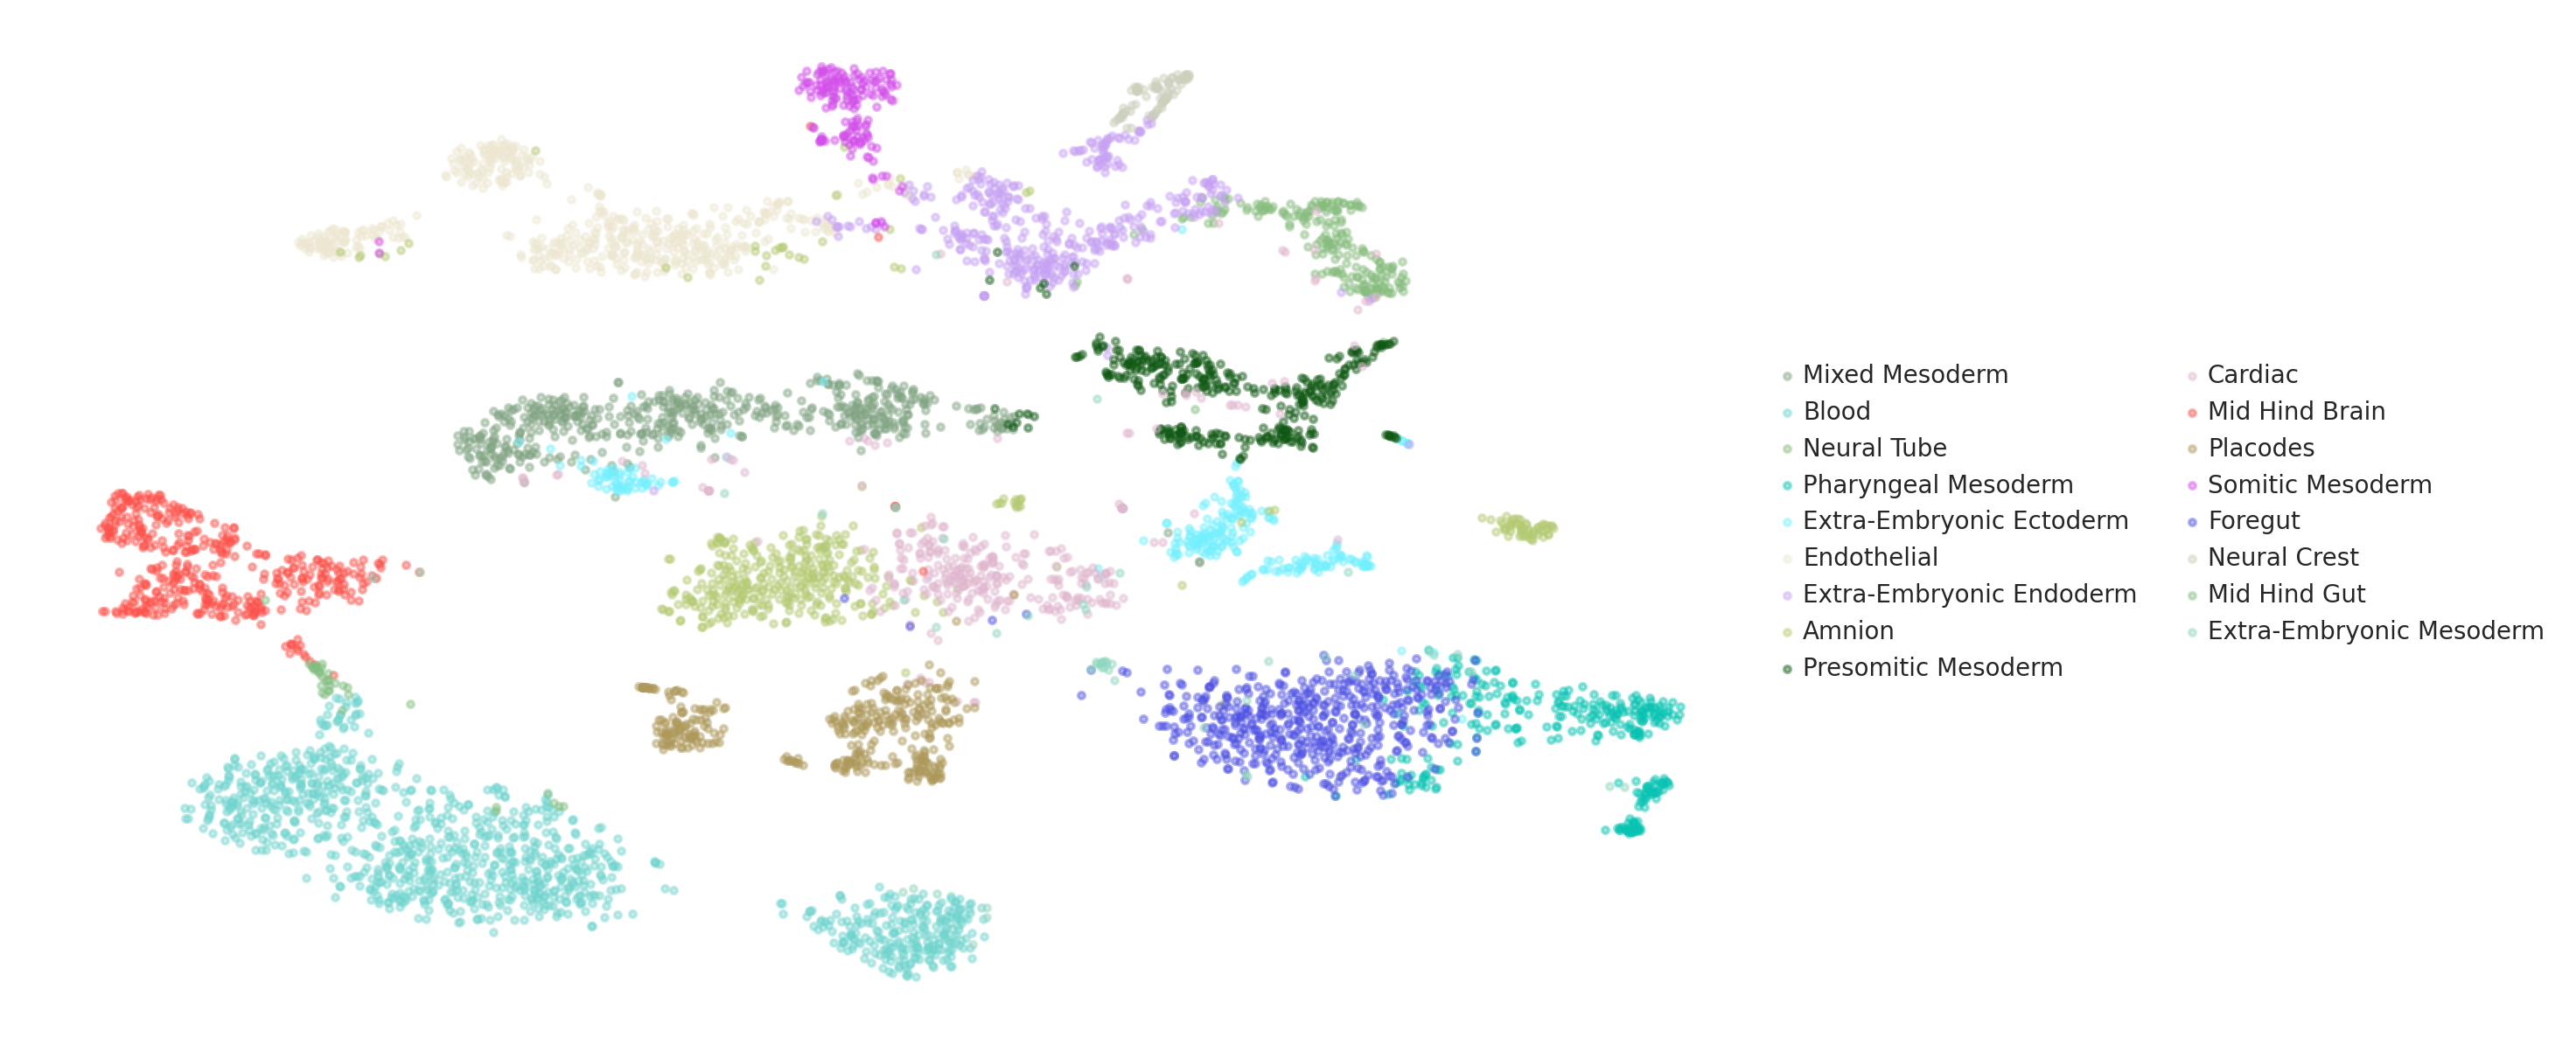

In [ ]:
#Plot

#PCA
tsvd = TruncatedSVD(n_components=2)
x_pca = tsvd.fit_transform(scaled_mat)
vis.obj_plot_embed(x_pca, np.array(fullNames), fname = '2DNCA.pdf', colors=colors ,figsize=(12,5))

tsvd = TruncatedSVD(n_components=50)
x_pca = tsvd.fit_transform(scaled_mat)

#UMAP
reducer = umap.UMAP(n_components = 2)
pcaUMAP = reducer.fit_transform(x_pca)
vis.obj_plot_embed(pcaUMAP, np.array(fullNames), fname = '2DNCA.pdf', colors=colors ,figsize=(12,5))

#t-SNE
tsne = TSNE(n_components = 2) 
pcaTSNE = tsne.fit_transform(x_pca)
vis.obj_plot_embed(pcaTSNE, np.array(fullNames), fname = '2DNCA.pdf', colors=colors ,figsize=(12,5))


In [ ]:
amb = tl.getCentroidDists(count_mat,labs[0], m='l2')
ambIntraC = tl.getIntraVar(count_mat, labs[0], labs[0],m='l2')

In [ ]:
batch_size = 128 #scaled_mat.shape[0]#len(adata.obs_names)
#Make a (unit) circle 
#r = 1
theta = np.linspace(0, 2*np.pi, batch_size)
# #Turkey guy
# x, y = (np.sin(2**theta) - 1.7) * np.cos(theta), (np.sin(2**theta) - 1.7) * np.sin(theta)

# #Butterfly r = 4*cos(4cosθ))
# x, y = (2*np.cos(4*np.cos(theta))) * np.cos(theta), (2*np.cos(4*np.cos(theta))) * np.sin(theta)

# # Spiral
#x, y = (1/2)*theta * np.cos(theta), (1/2)*theta * np.sin(theta)

# #Quasi-rose
x, y = (4 + np.cos(6*theta)) * np.cos(theta), (4 + np.cos(6*theta)) * np.sin(theta)


#Make array input for dimension of shape 
coords = np.array([list(x),list(y)])

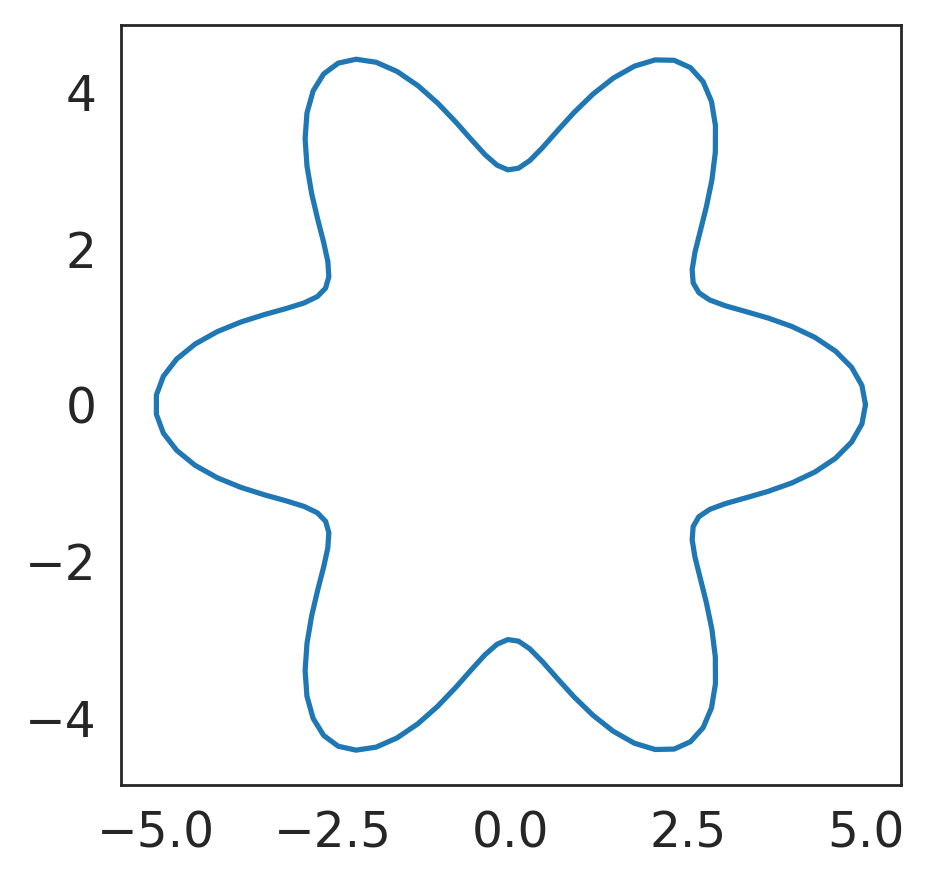

In [ ]:
plt.plot(x,y)

In [ ]:
#Ex utero 
fl = []
flLab = []
flType = []

for i in range(rounds):
  nca = Picasso(n_latent = 2, epochs = 1000, batch_size = batch_size)
  lossesB, latentB = nca.fit(scaled_mat,coords, frac = .06,silent=True,ret_loss=True)  #.06 for ex utero

  fl += [latentB]
  flLab += ['Flower']
  flType += ['MCML 2D']





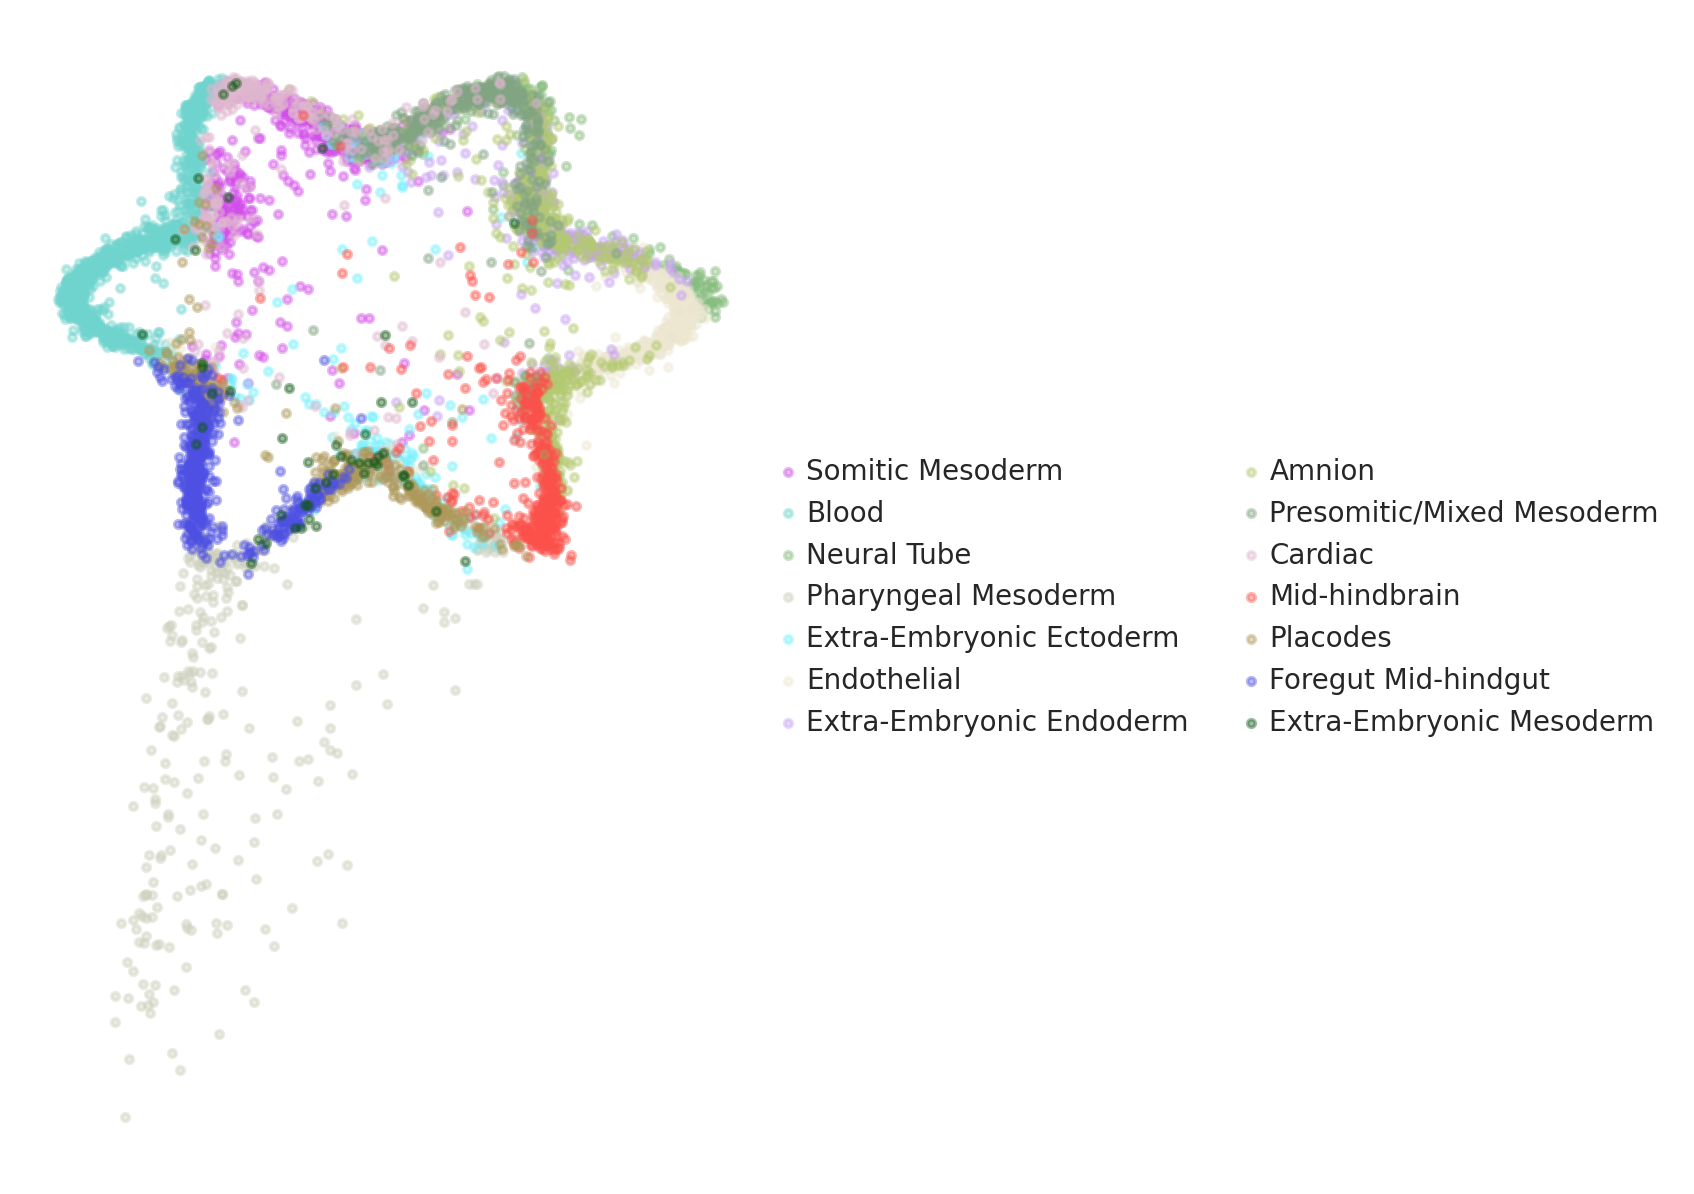

In [ ]:
vis.obj_plot_embed(latentB, np.array(fullNames), fname = '2DNCA.pdf', colors=colors ,figsize=(7,5))

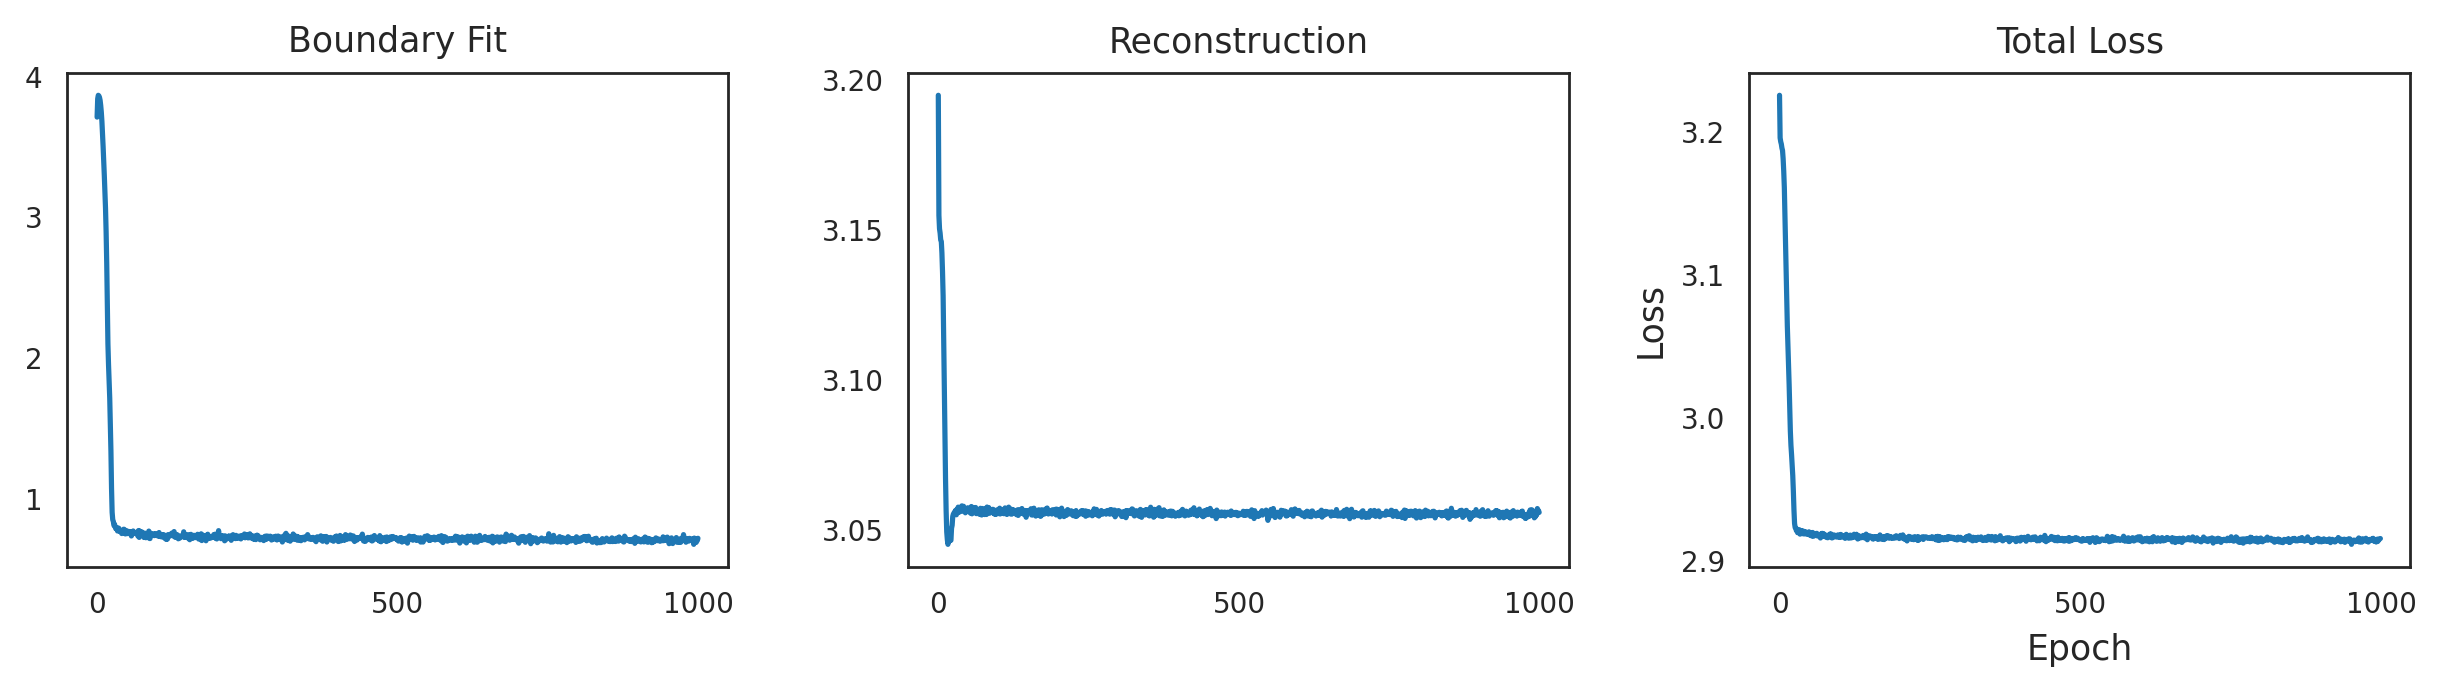

In [ ]:
nca.plotLosses(figsize=(10,3),axisFontSize=10,tickFontSize=8)

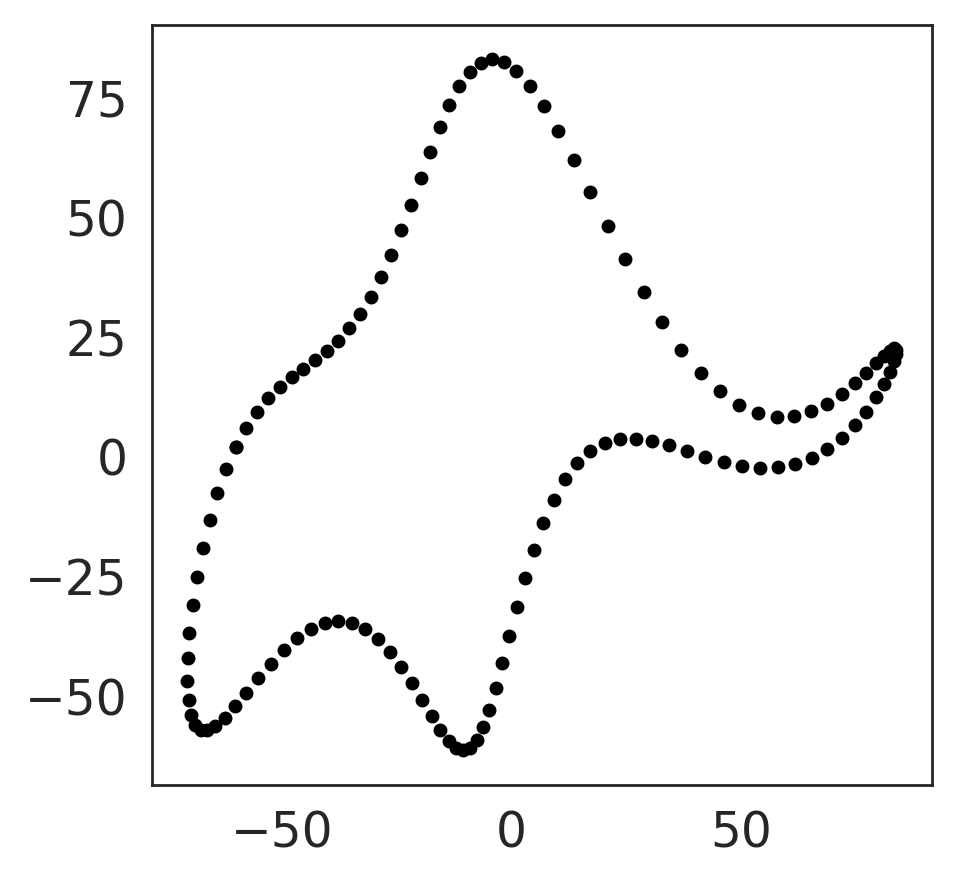

In [ ]:
# elephant parameters
batch_size = 128 #scaled_mat.shape[0]#3850 # 50

p1, p2, p3, p4 = (50 - 30j, 18 +  8j, 12 - 10j, -14 - 60j )
p5 = 40 + 20j # eyepiece

def fourier(t, C):
    f = np.zeros(t.shape)
    A, B = C.real, C.imag
    for k in range(len(C)):
        f = f + A[k]*np.cos(k*t) + B[k]*np.sin(k*t)
    return f

def elephant(t, p1, p2, p3, p4, p5):
    npar = 6
    Cx = np.zeros((npar,), dtype='complex')
    Cy = np.zeros((npar,), dtype='complex')

    Cx[1] = p1.real*1j
    Cx[2] = p2.real*1j
    Cx[3] = p3.real
    Cx[5] = p4.real

    Cy[1] = p4.imag + p1.imag*1j
    Cy[2] = p2.imag*1j
    Cy[3] = p3.imag*1j

    # x = np.append(fourier(t,Cx), [-p5.imag]) #[-p5.imag]
    # y = np.append(fourier(t,Cy), [p5.imag]) #[p5.imag]
    x = fourier(t,Cx)
    y = fourier(t,Cy)

    return x,y

x, y = elephant(np.linspace(0,2*np.pi,batch_size), p1, p2, p3, p4, p5)

#Make array input for dimension of shape 

y = y#0.04*y #.025  .025    .025
x = x#0.02*x #.015   .02     .015
# y = 0.02*y  
# x = 0.01*x

coords = np.array([list(y),list(-x)])

plt.plot(y,-x,'.',c='black')
plt.show()


In [ ]:
#Test with task assignment in-utero
el = []
elLab = []
elType = []

for i in range(rounds):
  nca = Picasso(n_latent = 2, epochs = 1000, batch_size = batch_size)
  lossesEl, latentEl = nca.fit(scaled_mat,coords, frac = 0.008,silent=True,ret_loss=True)

  el += [latentEl]
  elLab += ['Elephant']
  elType += ['MCML 2D']




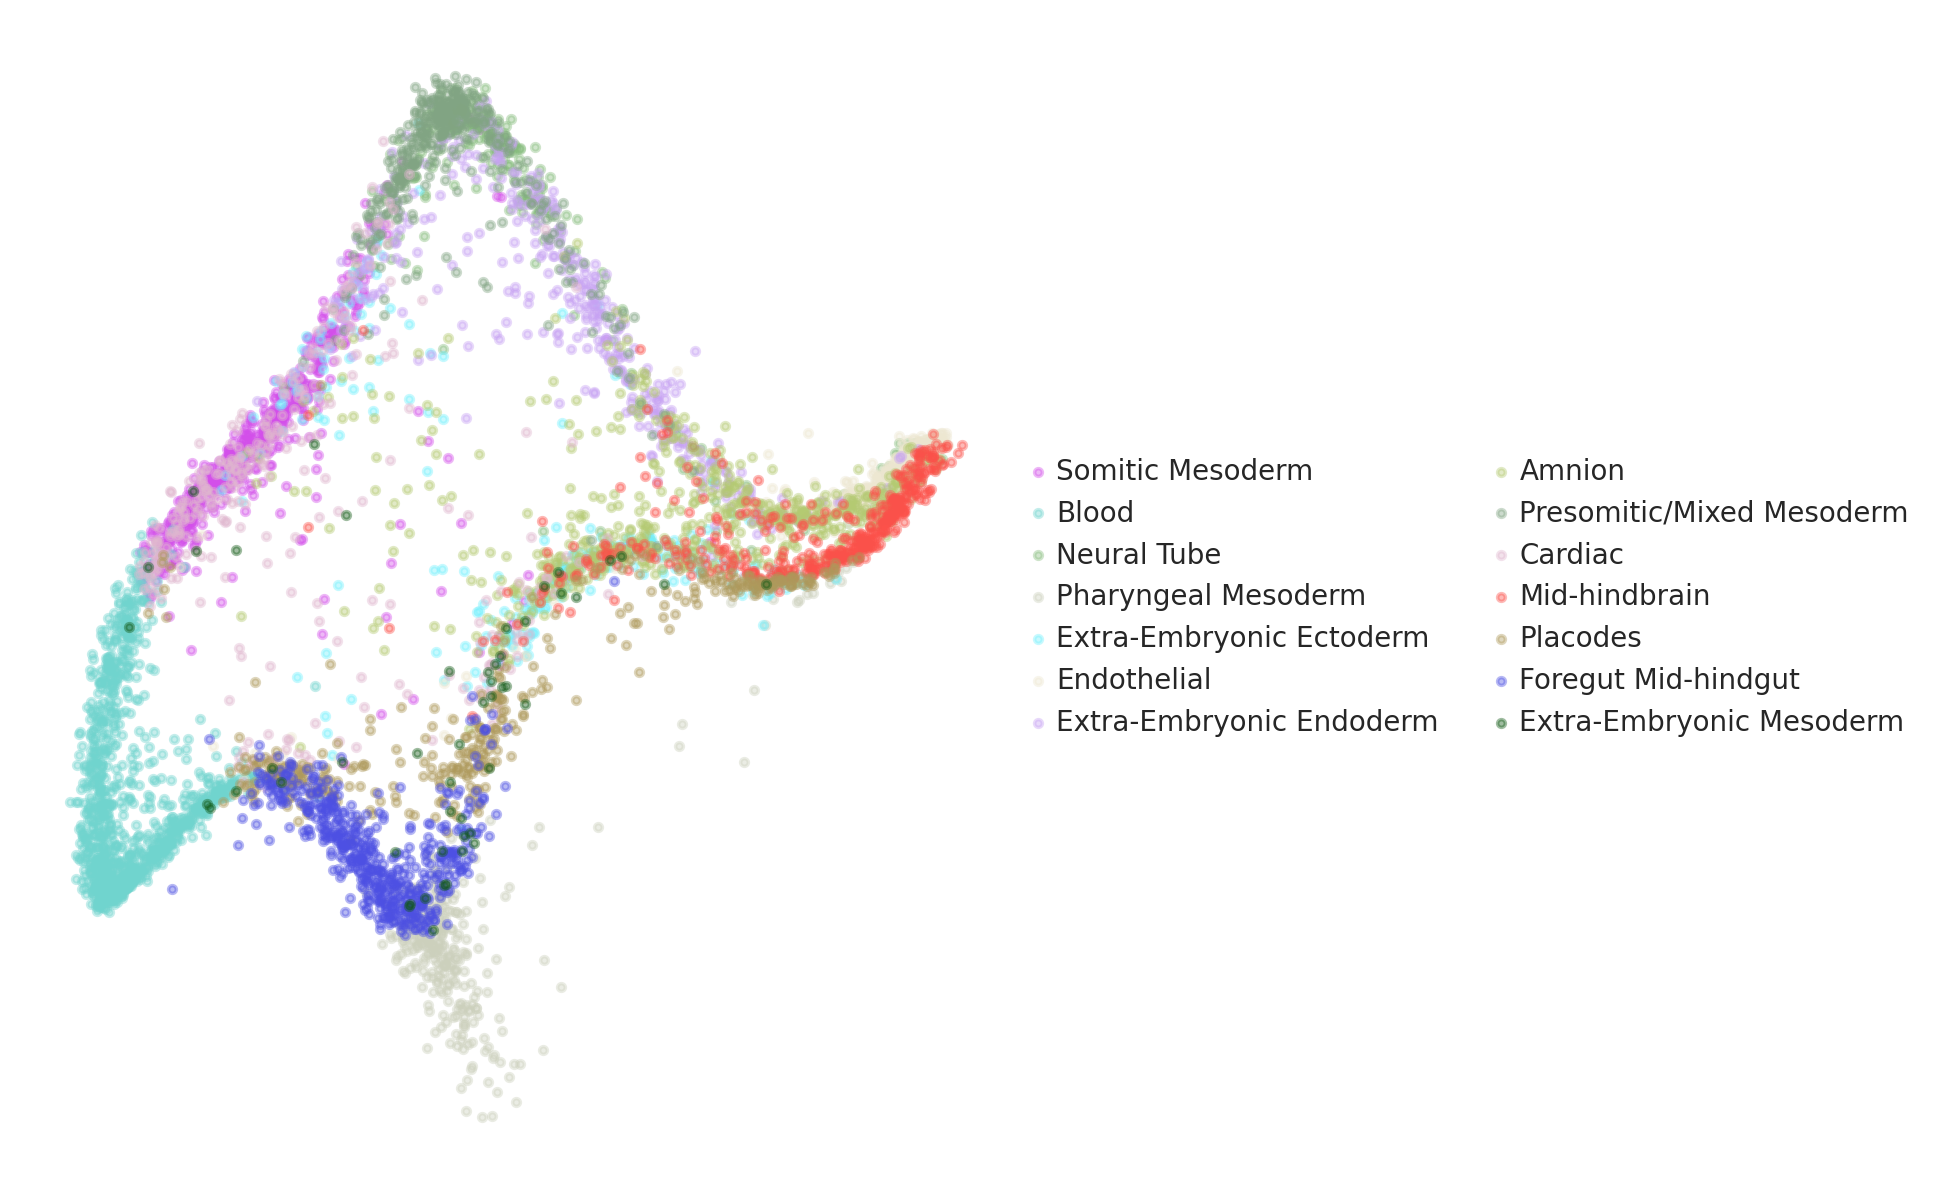

In [ ]:

vis.obj_plot_embed(el[0], np.array(fullNames), fname = '2DNCA.pdf', colors=colors,figsize=(8,5) ) 

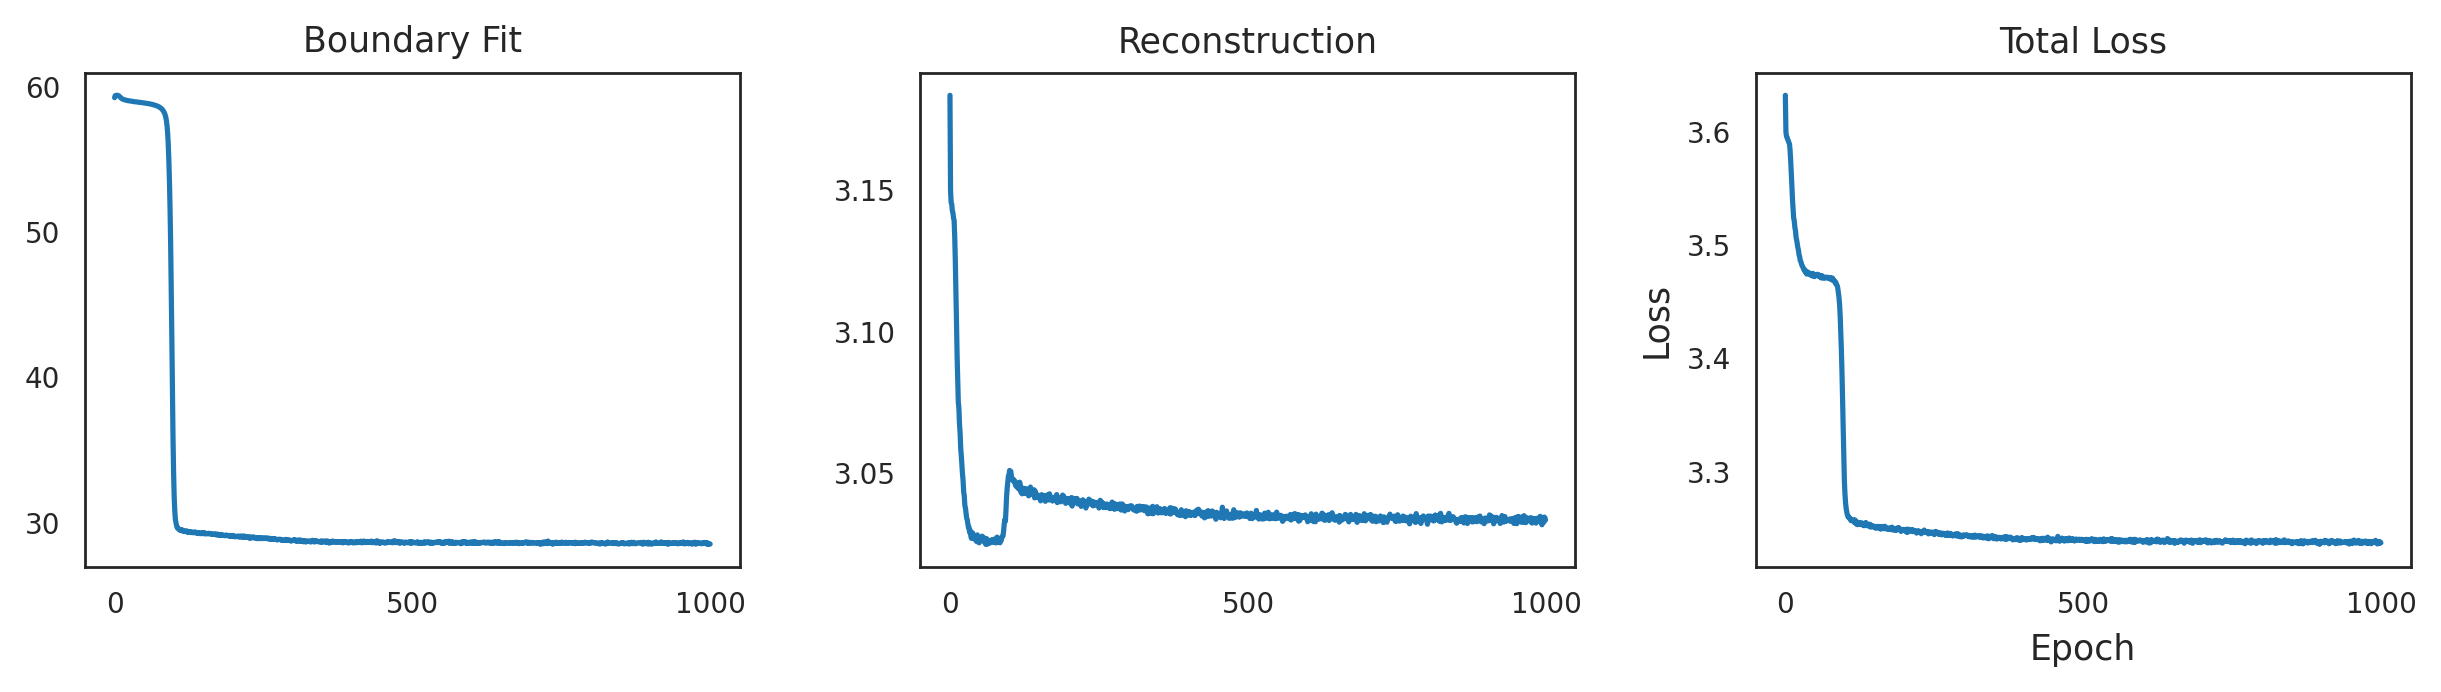

In [ ]:
nca.plotLosses(figsize=(10,3),axisFontSize=10,tickFontSize=8)

Save KNN Jaccard Dists

In [ ]:
orig_indices = tl.getNeighbors(count_mat, n_neigh = 30,p=2)

In [ ]:
df = getJac(orig_indices,fl+el, flLab+elLab, 30,2)
df.to_csv('uteroPicAmb.csv')

Flower
0.9491063600266799
Flower
0.9468162221290621
Flower
0.9477867680019264
Flower
0.9466939400740527
Flower
0.9471844225067126
Elephant
0.9637455355767608
Elephant
0.9537141235500229
Elephant
0.952248580709742
Elephant
0.954131886788978
Elephant
0.9615890060023207


In [ ]:
from google.colab import files
files.download("uteroPicAmb.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

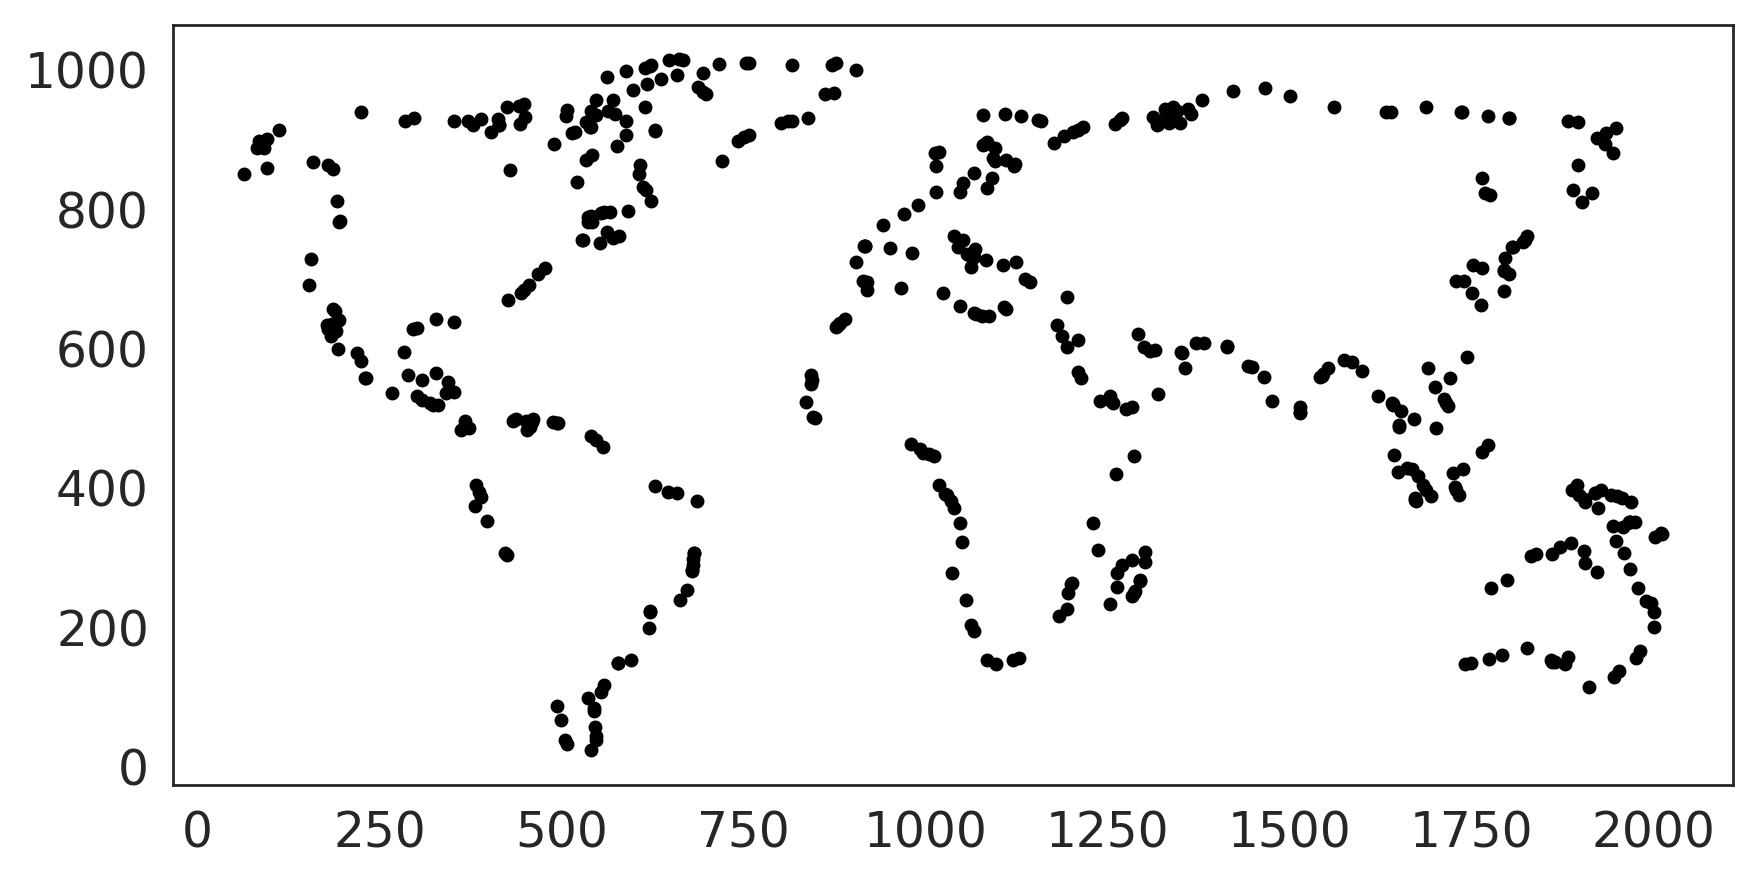

In [ ]:
# Map parameters
pts = pd.read_csv('../data/mapPoints.csv',header=None)
pts.head()

x = pts[0]
y = pts[1]
coords = np.array([x,y])

plt.figure(figsize=(8,4))
plt.plot(x,y,'.',c='black')
plt.show()


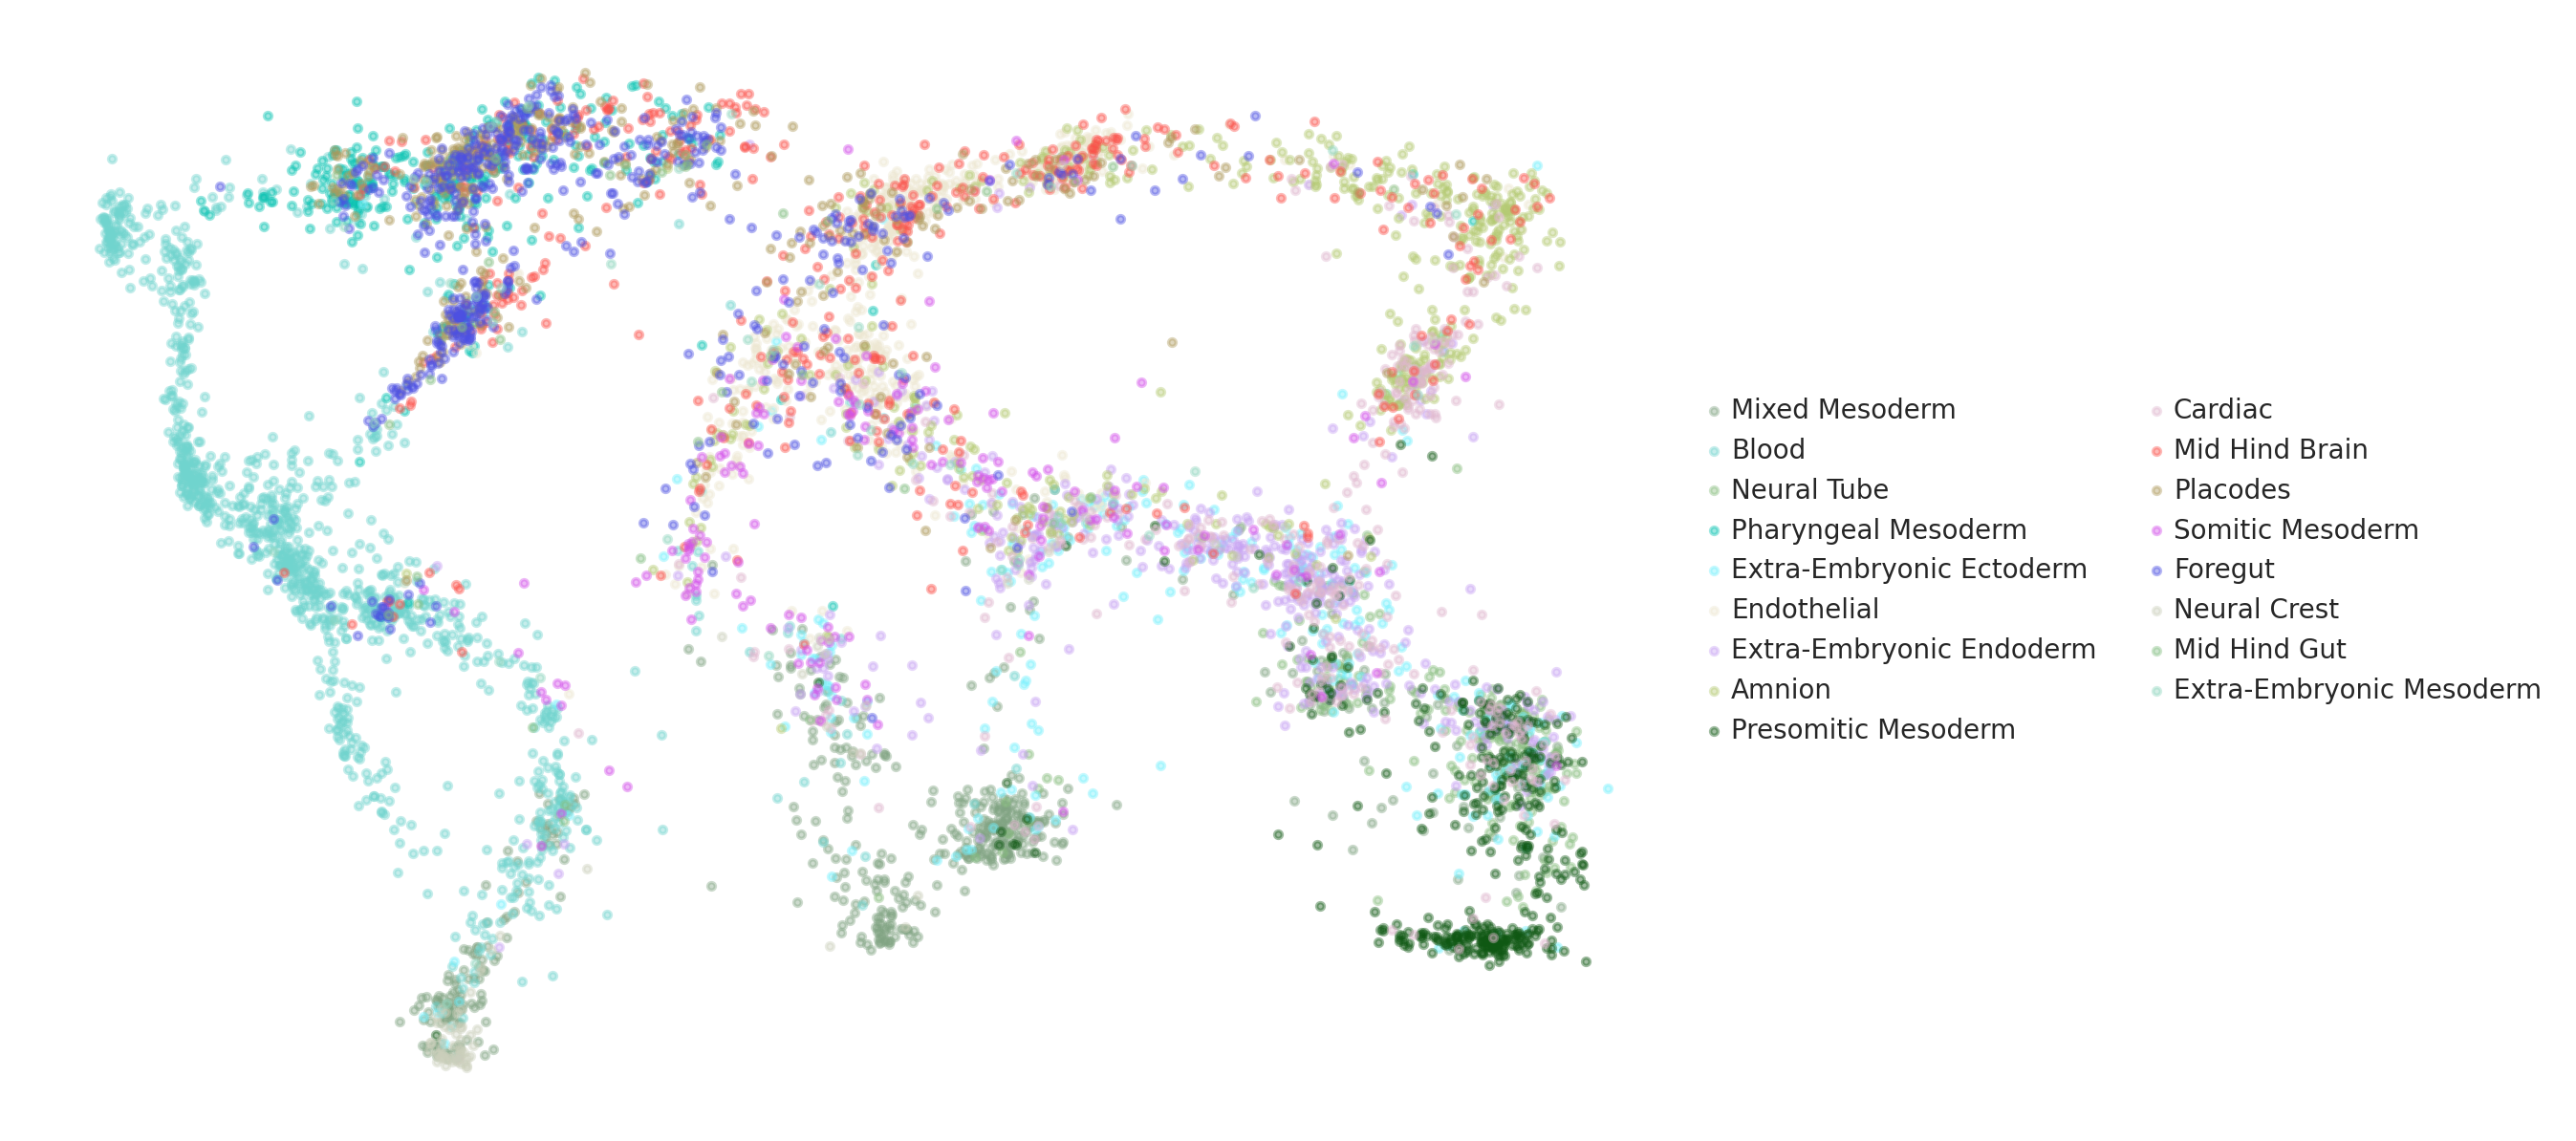

In [ ]:
#Test with task assignment 
batch_size = len(x)
rounds = 5

map = []
mapLab = []
mapType = []

for i in range(rounds):
  nca = Picasso(n_latent = 2, epochs = 1000, batch_size = batch_size)
  lossesMap, latentMap = nca.fit(scaled_mat,coords, frac = 0.95,silent=True,ret_loss=True)

  map += [latentMap]
  mapLab += ['Map']
  mapType += ['MCML 2D']


vis.obj_plot_embed(latentMap, np.array(fullNames), fname = '2DNCA.pdf', colors=colors,figsize=(11,5) )


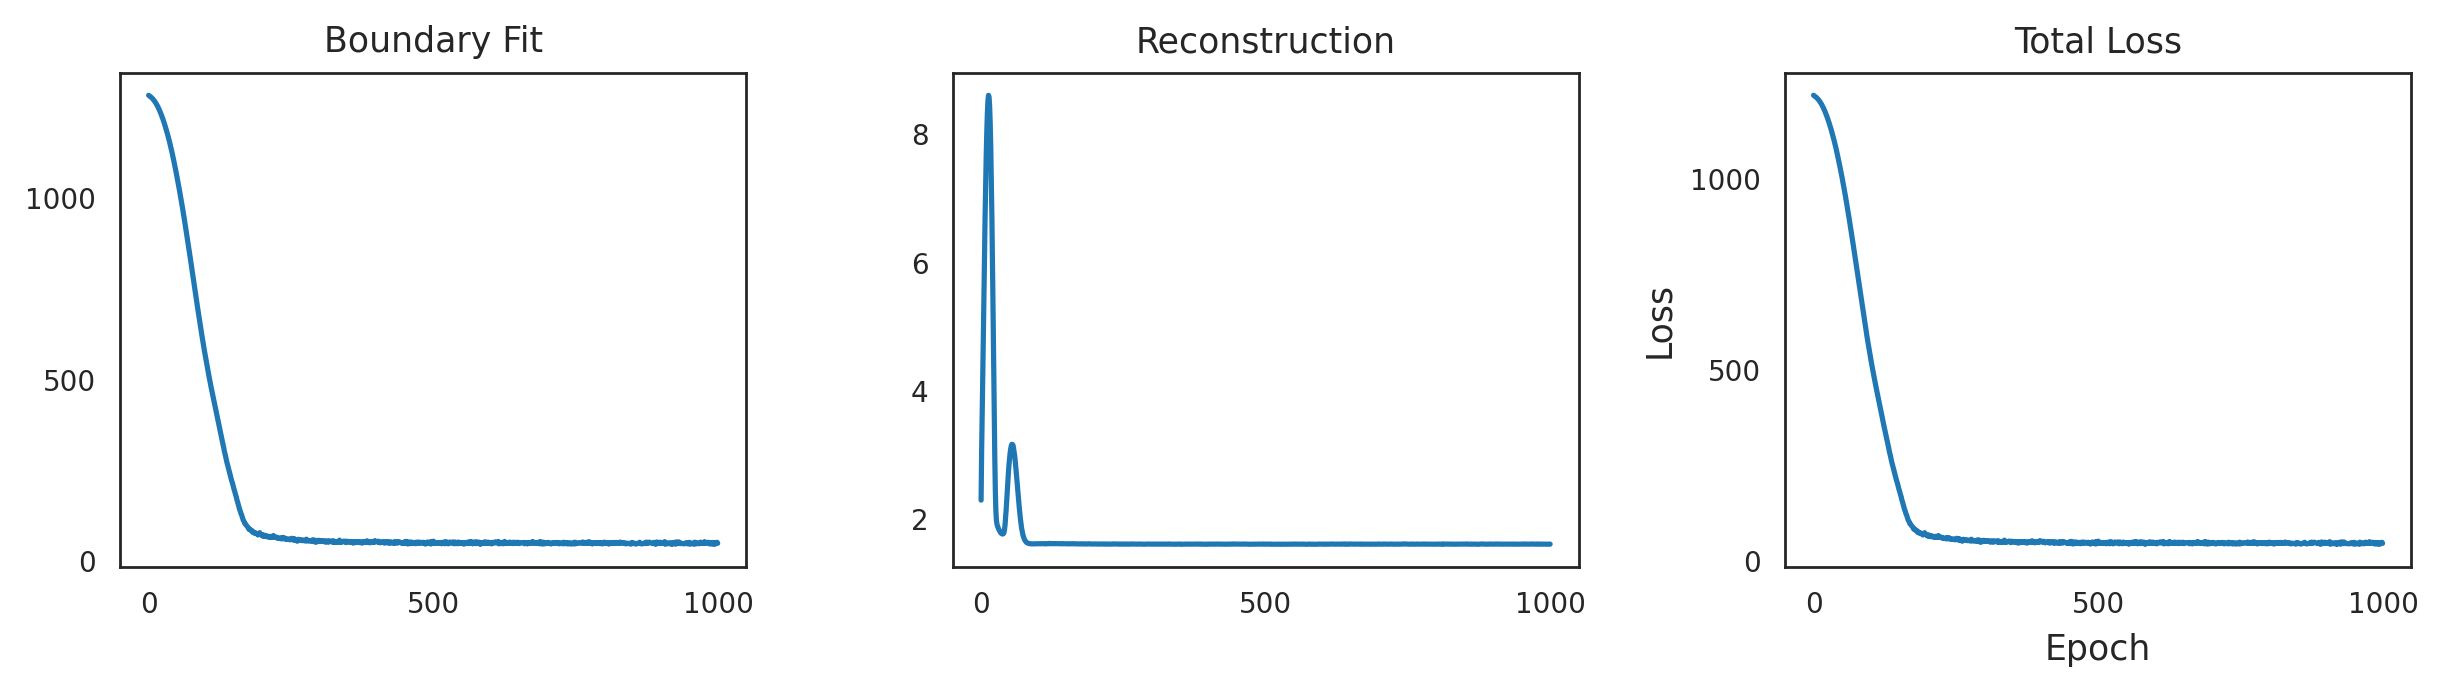

In [ ]:
nca.plotLosses(figsize=(10,3),axisFontSize=10,tickFontSize=8)

In [ ]:
# #Try with no learning
#batch_size = len(x)
rounds = 5

noT = []
noTLab = []
noTType = []

for i in range(rounds):

  nca = Picasso(n_latent = 2, epochs = 0 ) #batch_size = batch_size
  lossesNoT, latentNoT = nca.fit(scaled_mat,coords, frac = 1,silent=True,ret_loss=True)

  noT += [latentNoT]  
  noTLab += ['No Training']
  noTType += ['Picasso 2D']



# vis.obj_plot_embed(latentNoT, meta.smartseq_cluster, fname = '2DNCA.pdf', colors=clus_colors )


Get latent spaces for comparison (baselines)

In [ ]:
latents,latentLab,latentType = tl.visComp(scaled_mat, ndims=2, pcs=50)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default lea

Compare No Training Embedding

In [ ]:
latentsnoT = noT + latents

latentLabnoT = noTLab + latentLab

latentTypenoT = noTType + latentType

In [ ]:
allVals = getAllVars(latentsnoT,latentLabnoT,latentTypenoT )
allVals = allVals[~allVals['Latent'].isin(['PCA 50D'])]

In [ ]:
allVals['Latent'] = [i.replace('TSNE','t-SNE') for i in allVals['Latent']]
allVals['Latent'] = [i.replace('densSNE','dens-SNE') for i in allVals['Latent']]

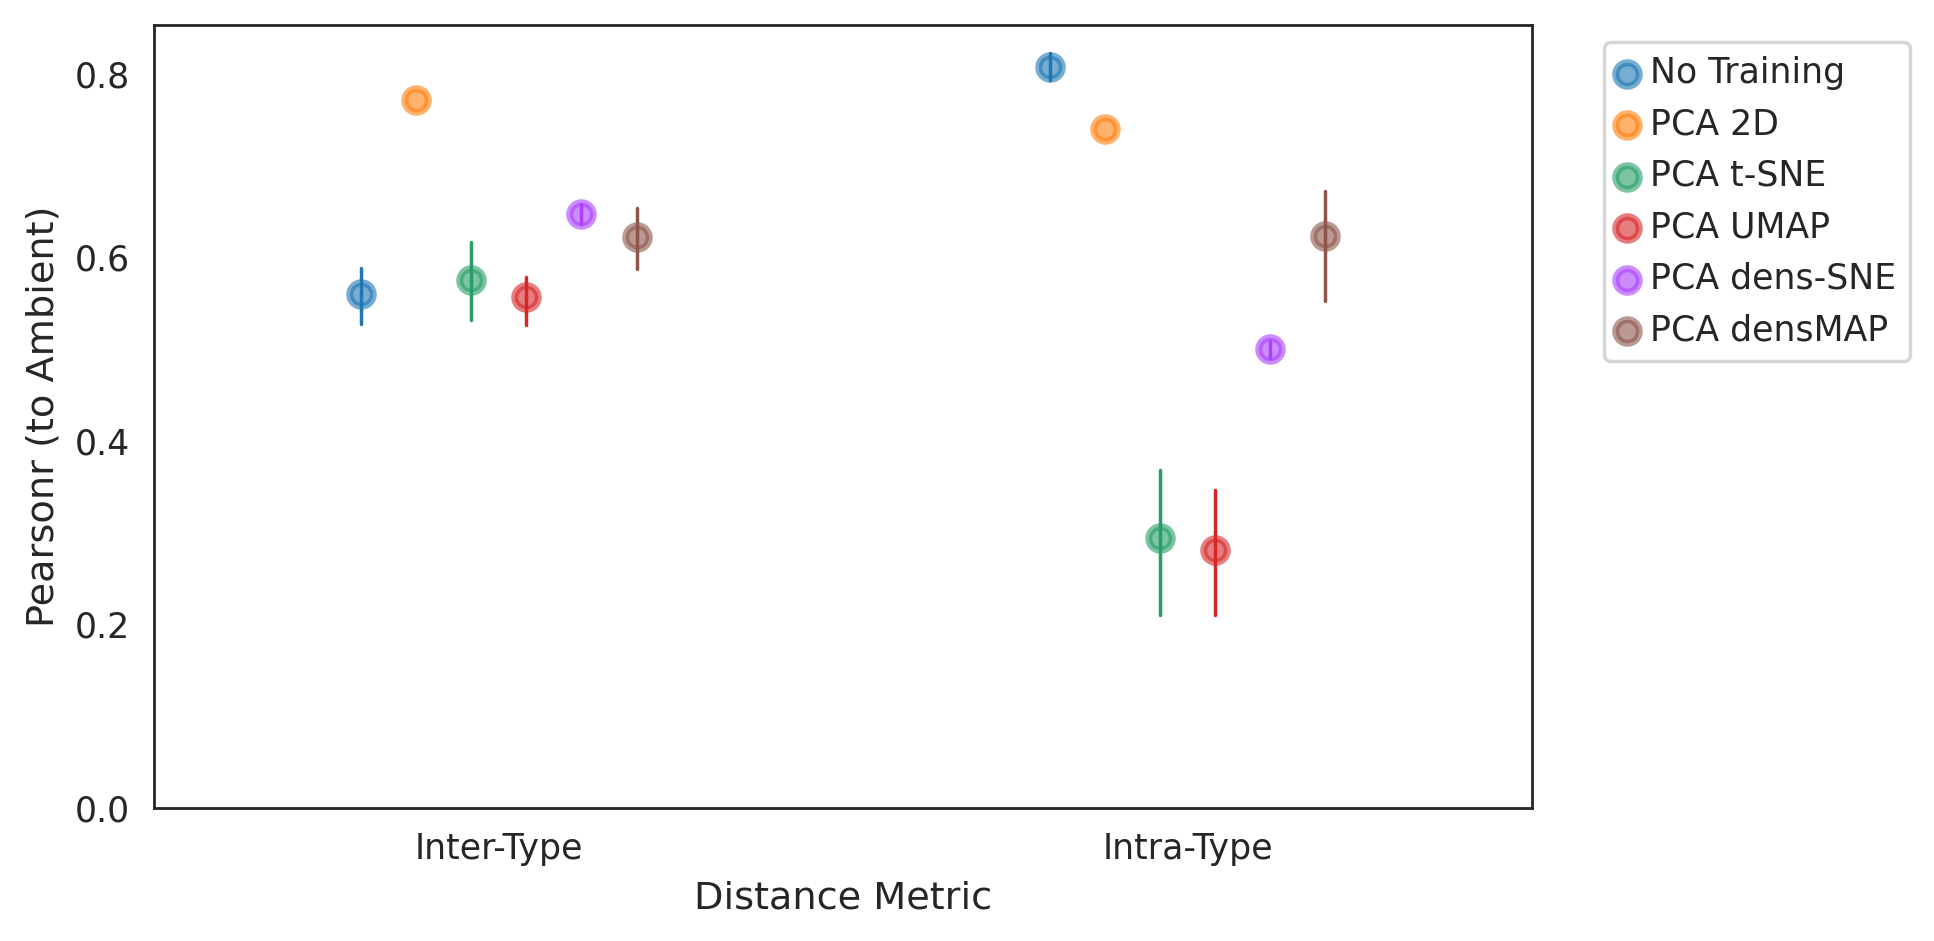

In [ ]:
vis.plotLatentStats(allVals, axisFontSize = 11, tickFontSize = 10)

Compare flower embedding

In [ ]:
latents = fl + latents

latentLab = flLab + latentLab

latentType = flType + latentType

In [ ]:
allVals = getAllVars(latents,latentLab,latentType)


In [ ]:
allVals = allVals[~allVals['Latent'].isin(['PCA 50D','Elephant','Map'])]

In [ ]:
toRemove = ['Recon MCML denSNE','PCA densSNE','Recon MCML densMAP','PCA densMAP','PCA 50D']
subAllVals = allVals[~allVals['Latent'].isin(toRemove)]

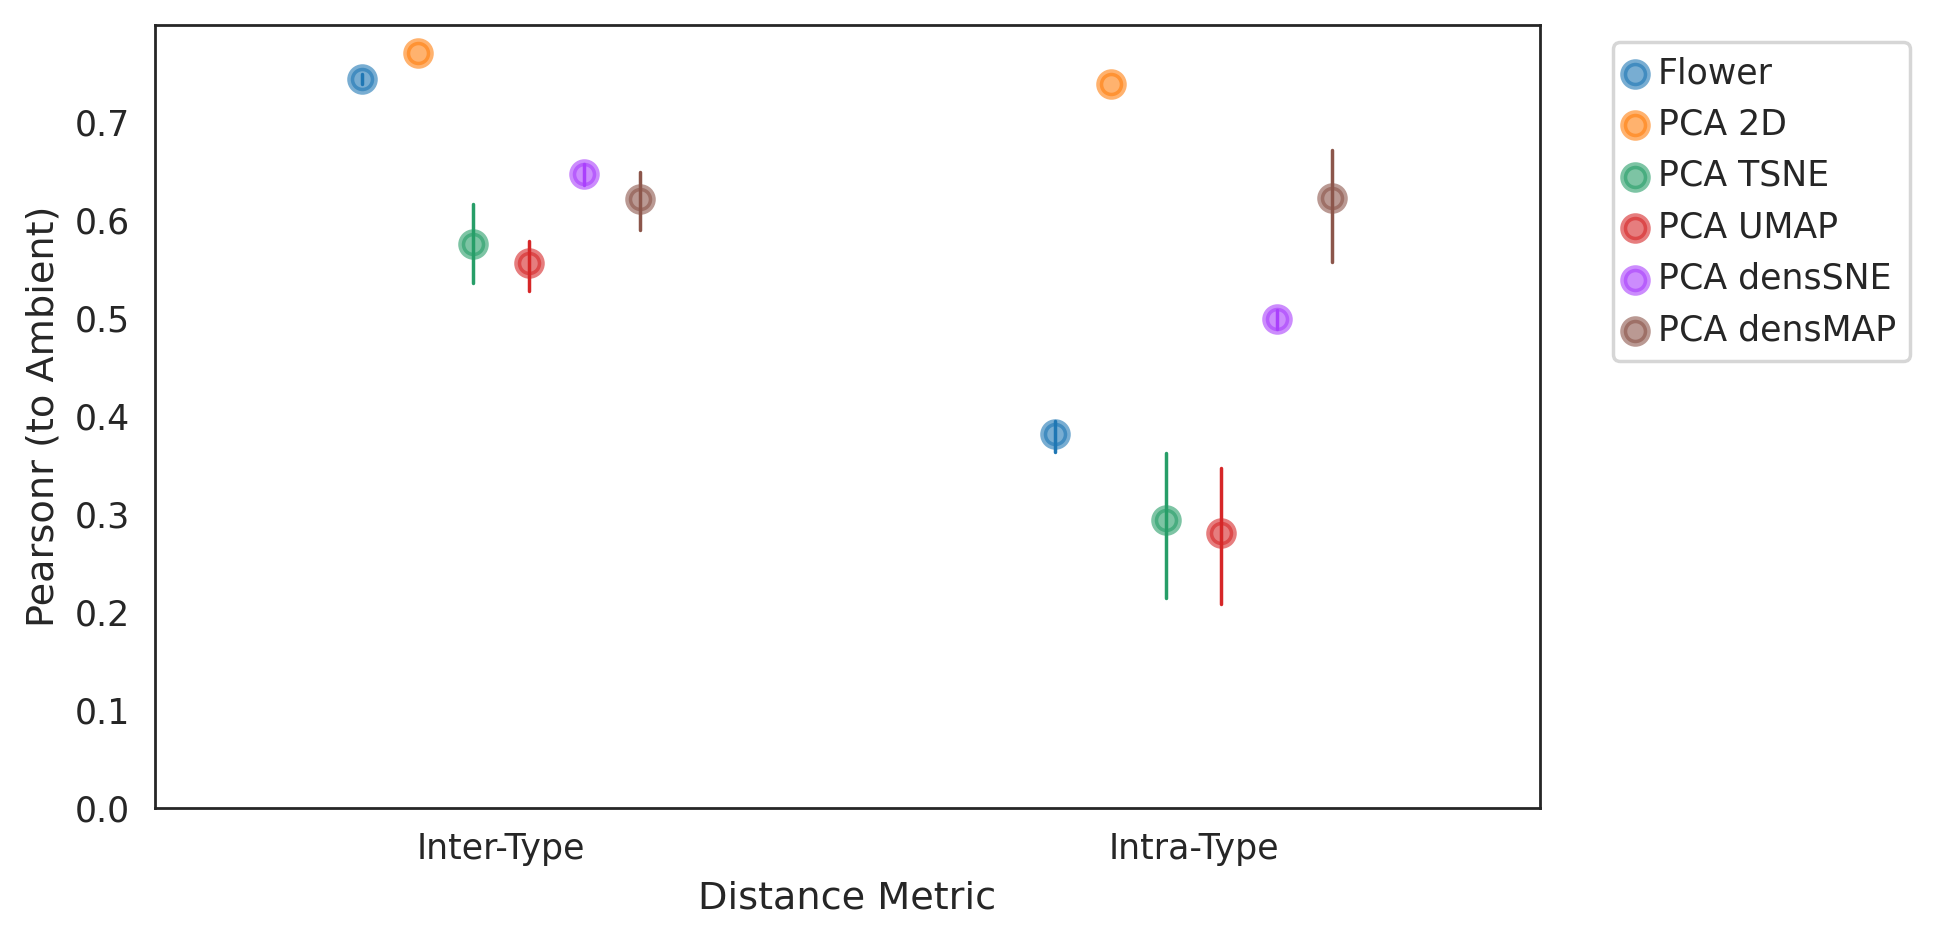

In [ ]:
vis.plotLatentStats(allVals, axisFontSize = 11, tickFontSize = 10, fname = None)

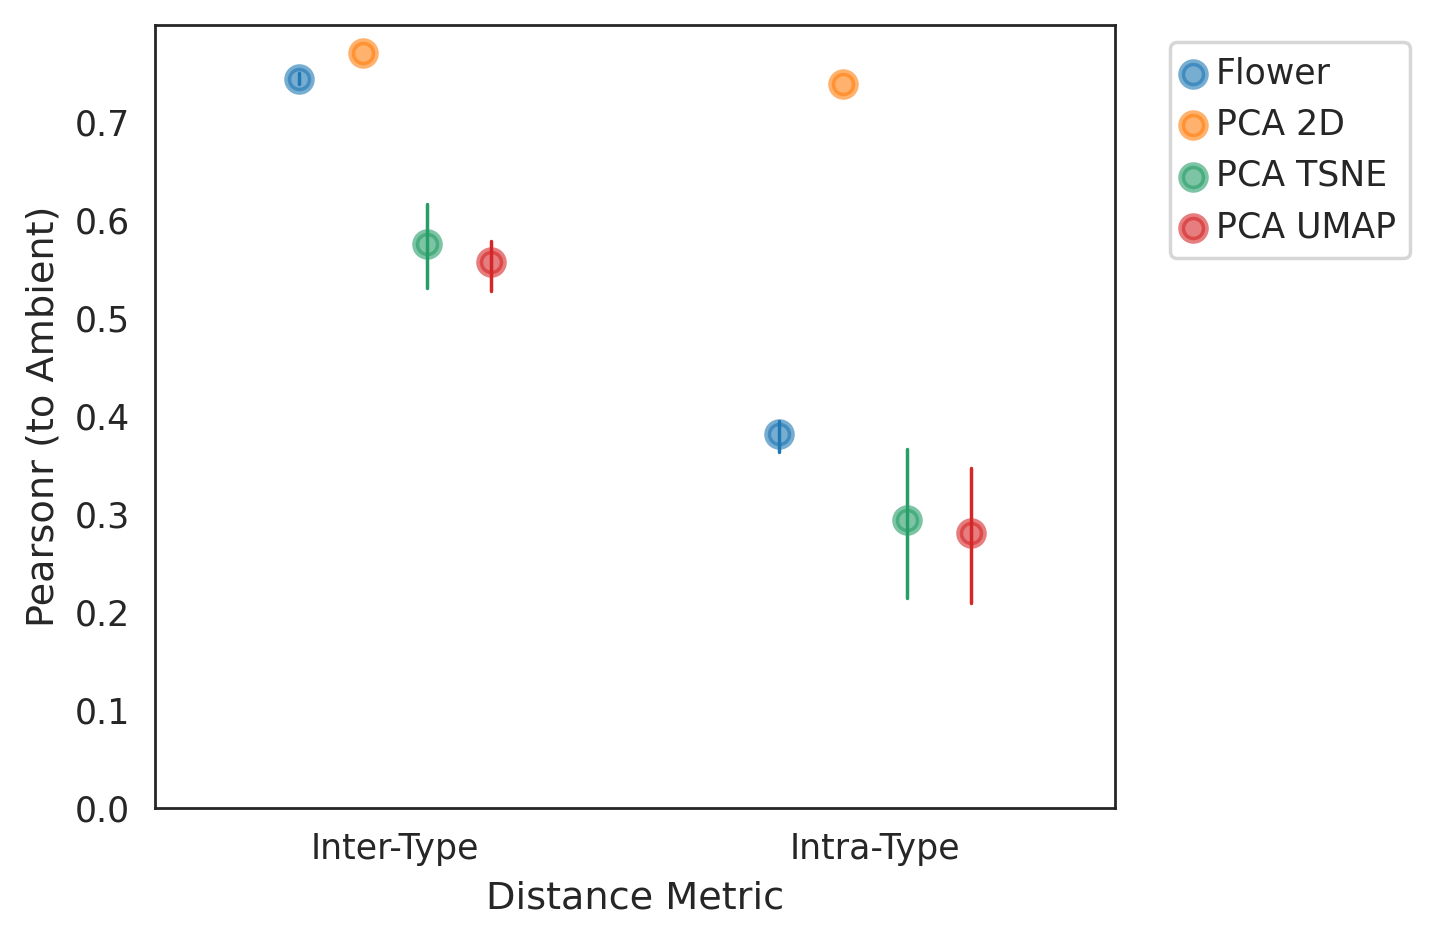

In [ ]:
vis.plotLatentStats(subAllVals, axisFontSize = 11, tickFontSize = 10, fname = None,figsize=(6,4))

Compare elephant embedding

In [ ]:
latents = el + latents

latentLab = elLab + latentLab

latentType = elType + latentType

In [ ]:
allVals = getAllVars(latents,latentLab,latentType)
allVals = allVals[~allVals['Latent'].isin(['Flower','PCA 50D'])]

In [ ]:
toRemove = ['Recon MCML denSNE','PCA densSNE','Recon MCML densMAP','PCA densMAP','PCA 50D']
subAllVals = allVals[~allVals['Latent'].isin(toRemove)]

In [ ]:
toRemove = ['Intra-Gender','Inter-Gender']
subDistAllVals = subAllVals[~subAllVals['Distance'].isin(toRemove)]

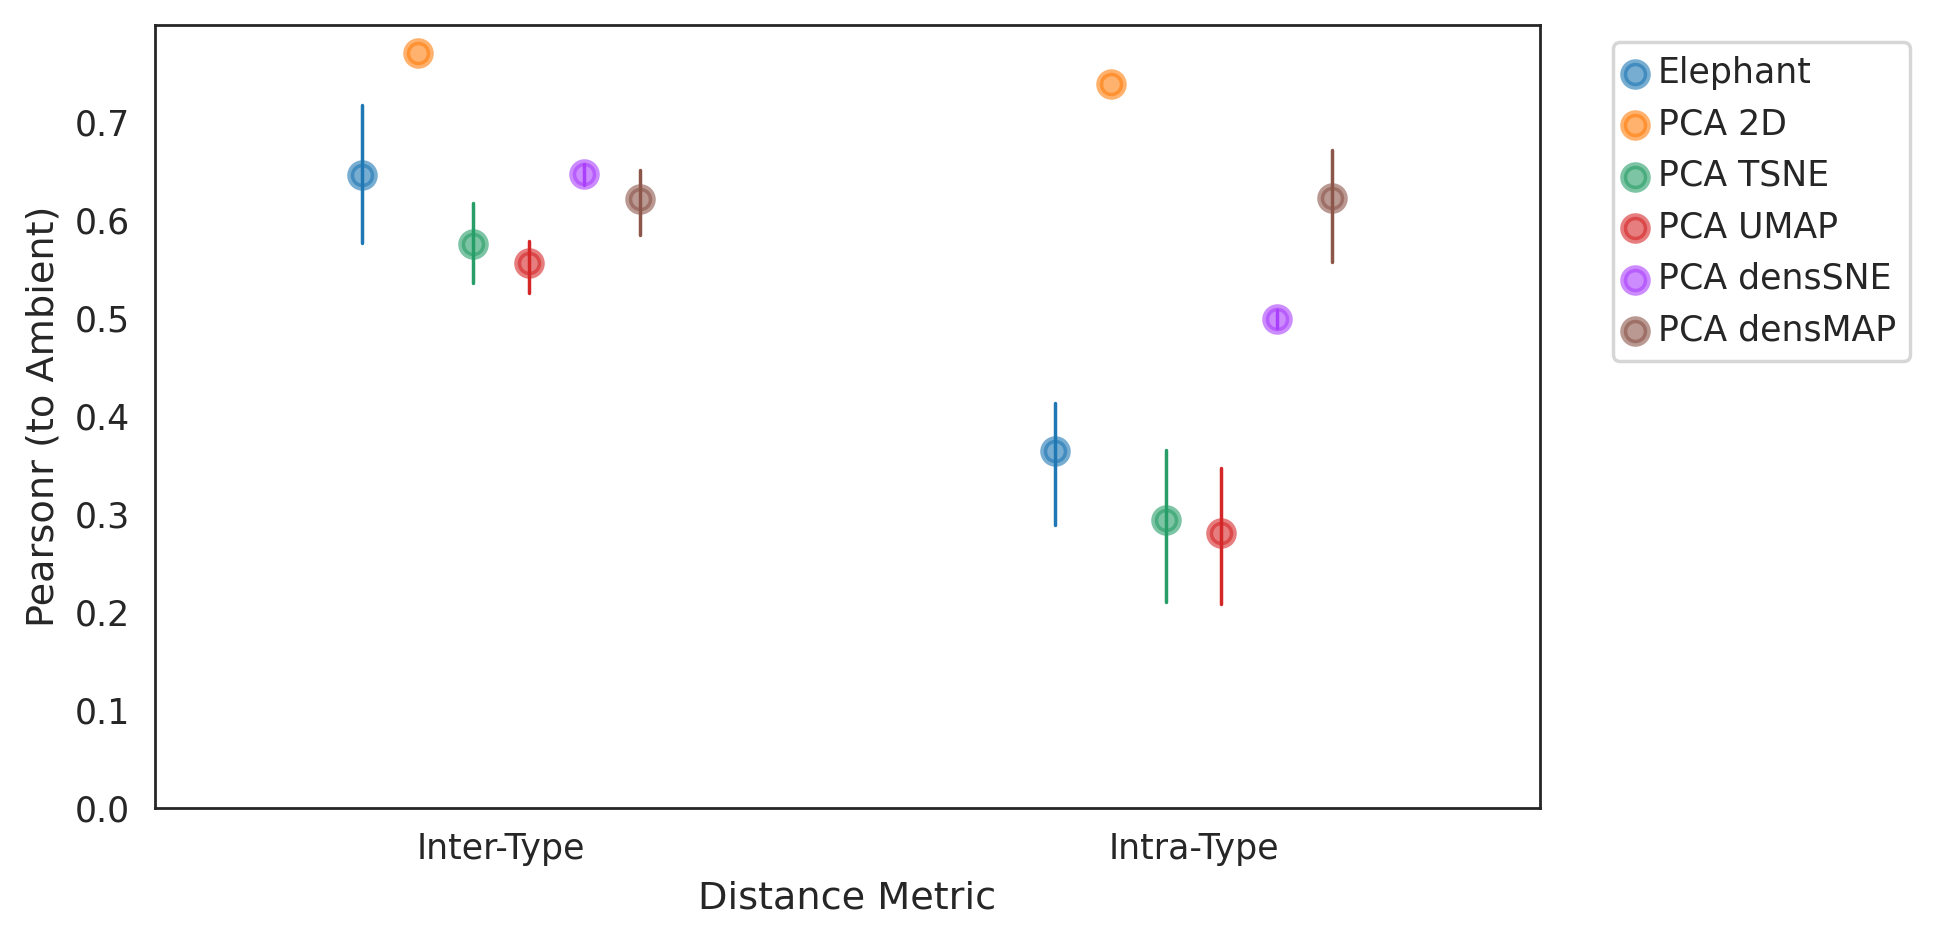

In [ ]:
vis.plotLatentStats(allVals, axisFontSize = 11, tickFontSize = 10, fname = None)

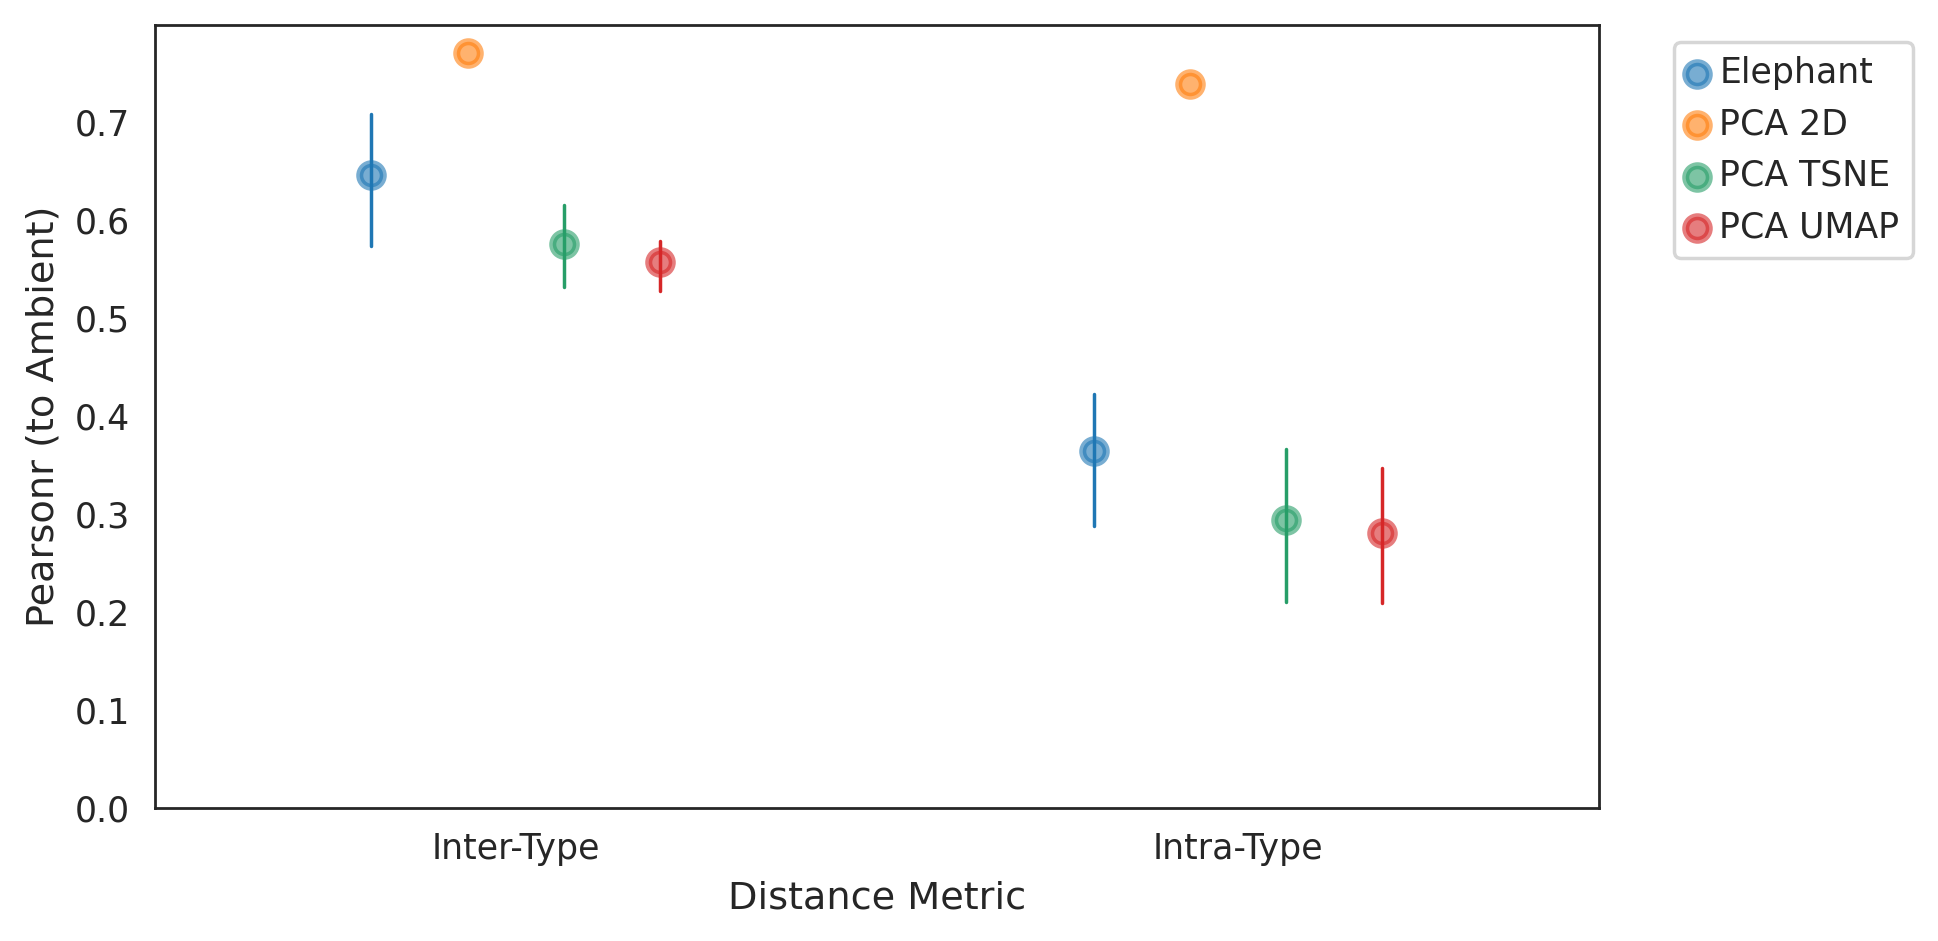

In [ ]:
vis.plotLatentStats(subAllVals, axisFontSize = 11, tickFontSize = 10, fname = None)

Compare map embedding

In [ ]:
latents = map + latents#[1:]

latentLab = mapLab + latentLab#[1:]

latentType = mapType + latentType#[1:]

In [ ]:
allVals = getAllVars(latents,latentLab,latentType)


from google.colab import files

allVals.to_csv('exUtElMapVals.csv')
files.download('exUtElMapVals.csv')


allVals = allVals[~allVals['Latent'].isin(['Elephant'])]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
allVals = allVals[~allVals['Latent'].isin(['PCA 50D','Flower'])]

In [ ]:
toRemove = ['Recon MCML denSNE','PCA densSNE','Recon MCML densMAP','PCA densMAP','PCA 50D']
subAllVals = allVals[~allVals['Latent'].isin(toRemove)]

In [ ]:
toRemove = ['Intra-Gender','Inter-Gender']
subDistAllVals = subAllVals[~subAllVals['Distance'].isin(toRemove)]

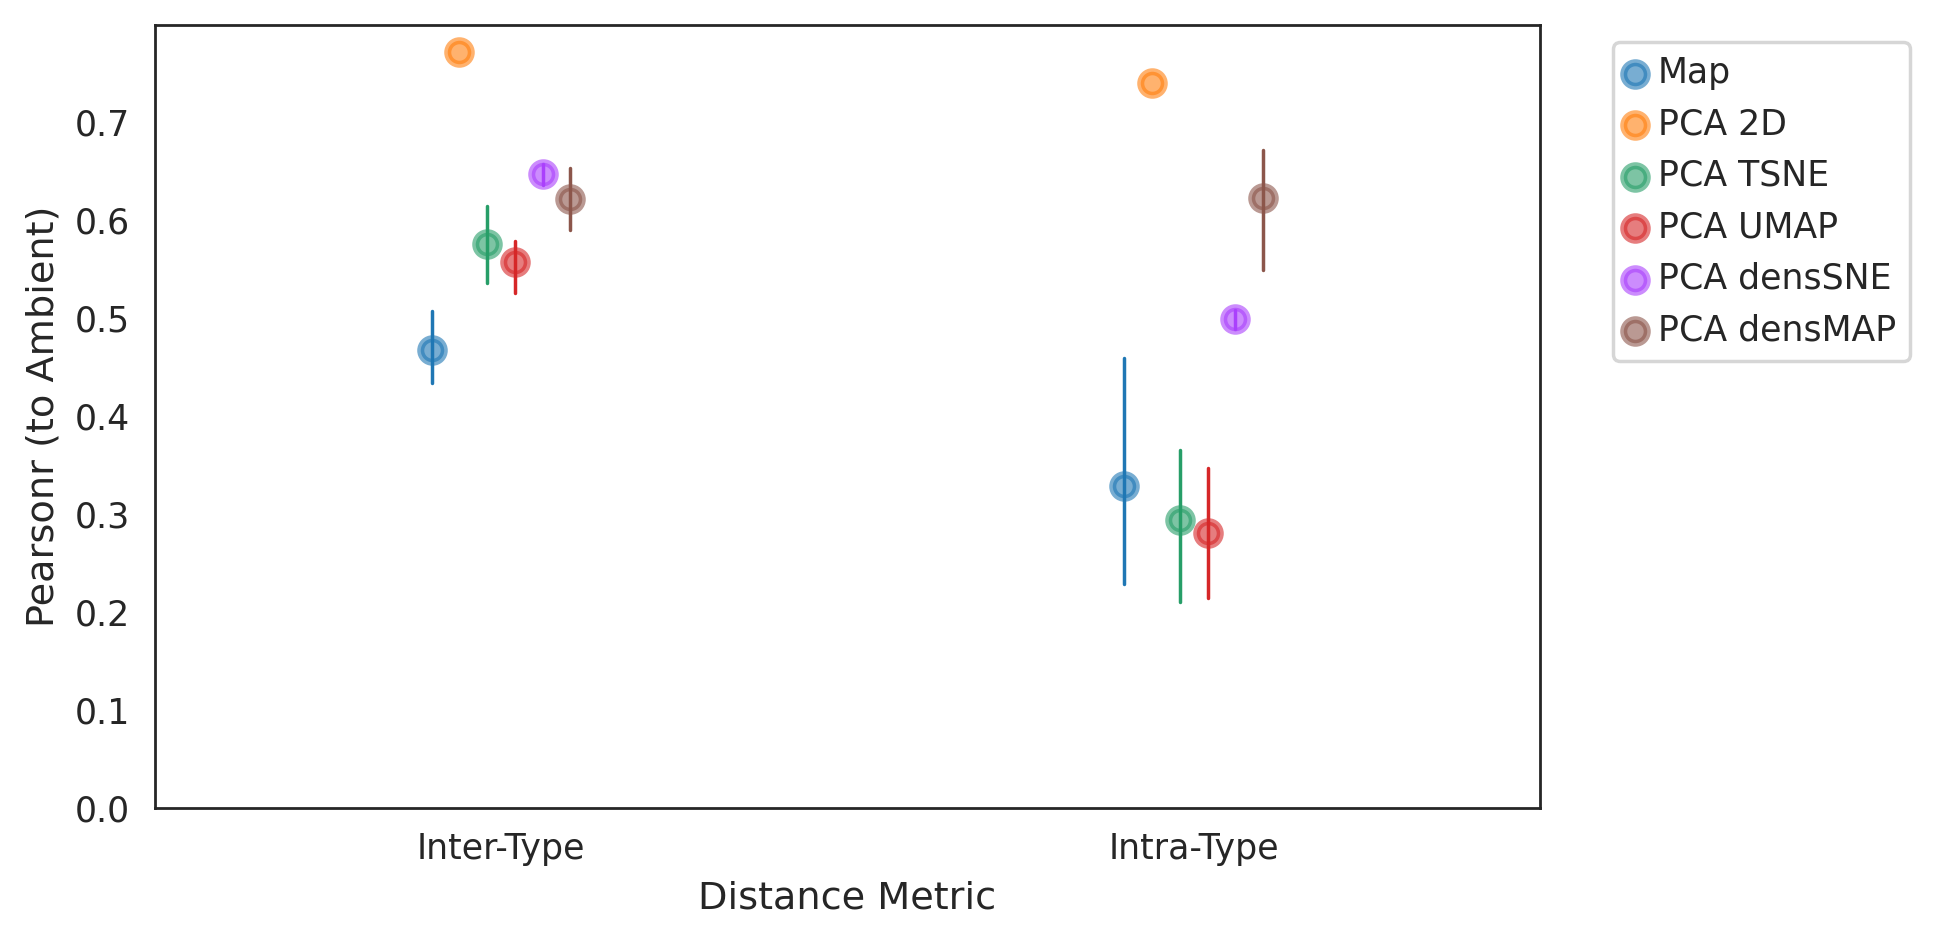

In [ ]:
vis.plotLatentStats(allVals, axisFontSize = 11, tickFontSize = 10, dodge=0.2) #0.95

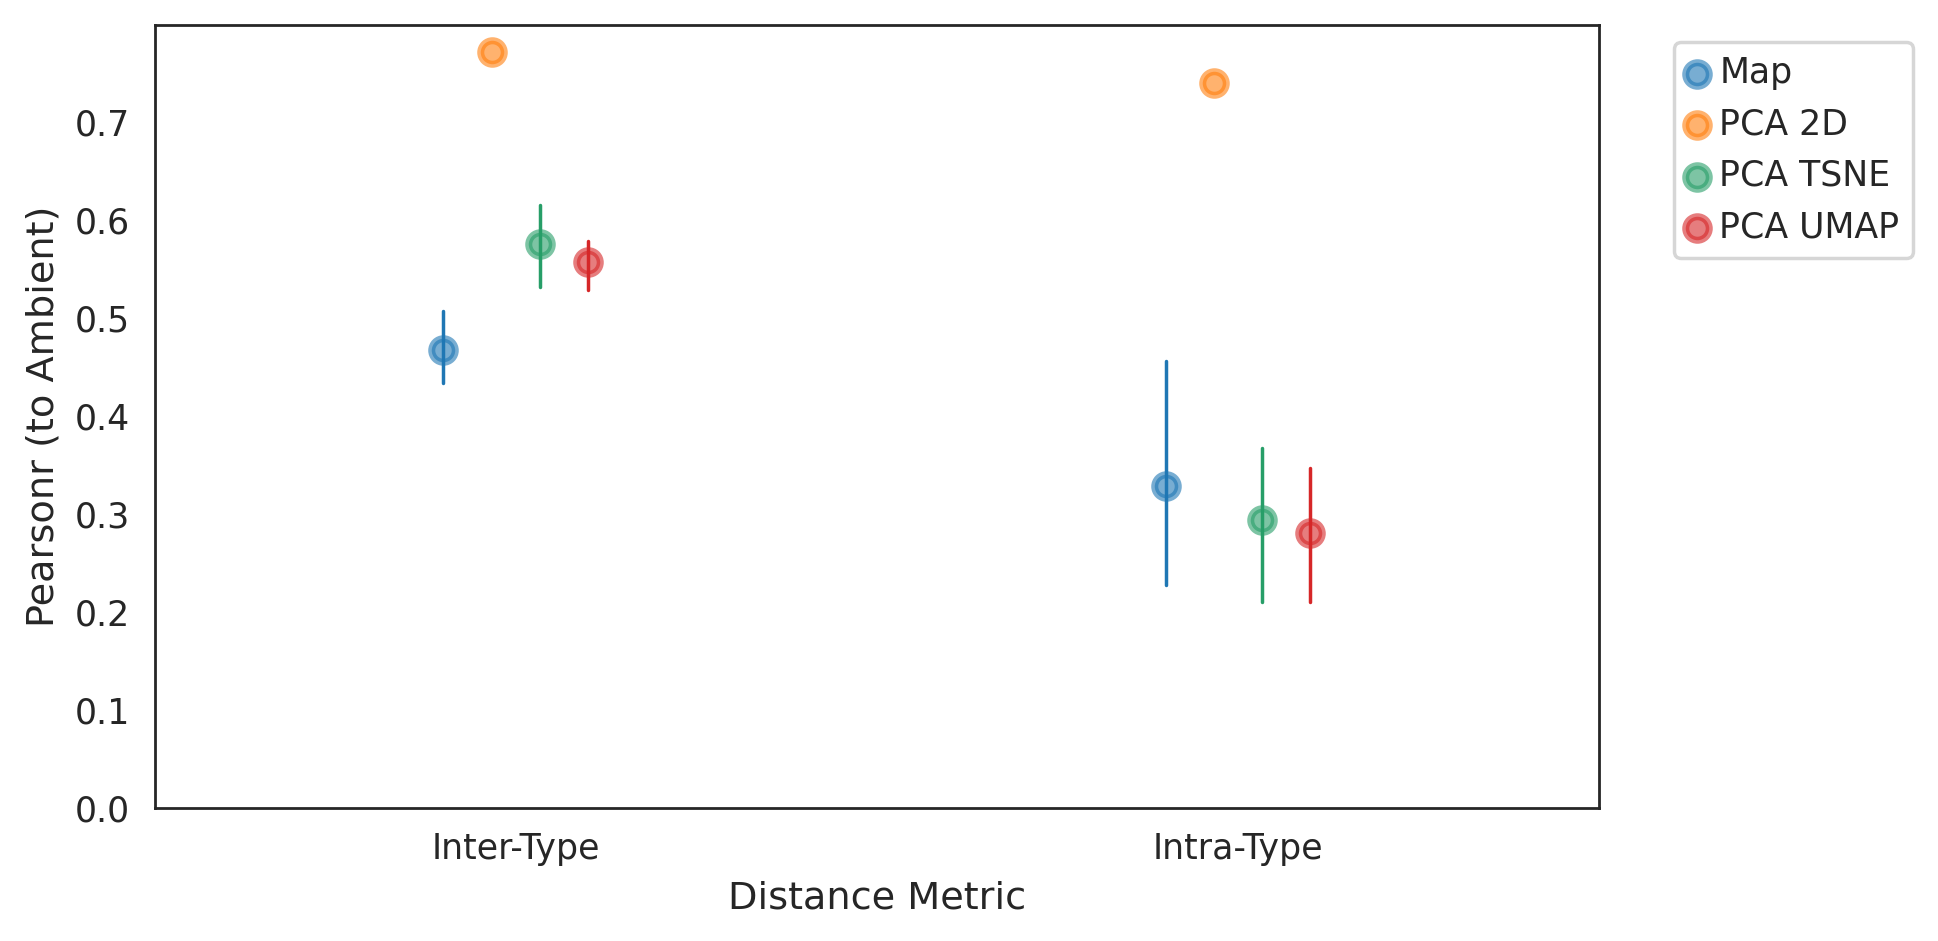

In [ ]:
vis.plotLatentStats(subAllVals, axisFontSize = 11, tickFontSize = 10, dodge=0.2)